# **DCDC Práctica Final: Predicción de Stock a corto plazo<a id="top"></a>**

<i><small>**Alumnos:** Che Cui y Alejandro Pequeño<br>Última actualización: 22/01/2024</small></i></div>

**Análisis y predicción a corto plazo de series de temporales de stock basadas en noticias para la asignatura de Descubrimineto de Conocimiento en Datos Complejos**

El siguiente notebook, presentará el proceso de análisis de una serie temporal de los valores de la bolsa europea y un pipeline de predicción de los valores futuros de la misma, usando métodos desde AR hasta SARIMAX. El motivo de realizar todos los métodos vistos en la asignatura, es para poder comparar los resultados de cada uno de ellos y ver cuál es el que mejor se ajusta a la serie temporal y también para ver el efecto que tienen las variables exógenas en los modelos de predicción para nuestro caso de estudio.

Para la parte de predicción con variables exógenas, usaremos un análisis de sentimientos que cada noticia tiene sobre las acciones de la bolsa europea. Dicho análisis de sentimiento está incluido en el [dataset de noticias de revistas francesas](https://www.kaggle.com/datasets/arcticgiant/french-financial-news). Usando este mismo dataset, obtendremos los valores de la bolsa en los días en los que se publicaron las noticias, para así poder usarlos como variables exógenas en los modelos de predicción. Para ello, nos ayudaremos de las librerías ``pandas-datareader`` e ``yfinance``, que nos permitirá obtener el valor de la bolsa en el día de publicación de la noticia.

Adicionalmente, se incluye un ánalisis de tópicos de las revistas financieras francesas para intentar obtener los valores que más influyen a que una noticia tenga un sentimiento positivo o negativo sobre la bolsa.

**NOTA:** El motivo de hacer una predicción de valores de bolsa a corto plazo y no a largo plazo es porque la bolsa es un mercado muy volátil y es muy difícil predecir los valores a largo plazo. Por ello, se ha decidido hacer una predicción a corto plazo, ya que es más fácil predecir los valores de la bolsa en un futuro cercano.

</br>
<center>

<img src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/UPM/Escudo%20con%20Leyenda/ESCUDO%20leyenda%20color%20JPG.jpg" width="500px">

</center>
</br>

---

**Índice:**

- [Imports](#-Imports)


- [1. Dataset](##-1.-Dataset)
  - [1.1 Carga y visualización](###-1.1-Carga-y-visualización)
  - [1.2 Preprocesado](###-1.2-Preprocesado)


- [2. Análisis del DataFrame](##-2.-Análisis-del-DataFrame)
  - [2.1 Descomposición de la serie temporal](###-2.1-Descomposición-de-la-serie-temporal)
  - [2.2 Prueba de Dickey-Fuller](###-2.2-Prueba-de-Dickey-Fuller)
  - [2.3 Análisis de la autocorrelación](###-2.3-Análisis-de-la-autocorrelación)


- [3. Métodos de Predicción](#-3.-Métodos-de-Predicción)
  - [3.1 AR, MA, ARMA](###-3.1-AR,-MA,-ARMA)
  - [3.2 ARIMA](###-3.1-ARIMA)
  - [3.2 SARIMA](###-3.2-SARIMA)
  - [3.3 SARIMAX](###-3.3-SARIMAX)

- [4. Análisis de tópicos](#-4.-Análisis-de-tópicos)

---


## Imports

In [134]:
# Imports
# =====================================================================
%pip install statsmodels
%pip install pandas-datareader
%pip install yfinance
%pip install --upgrade -q gspread
%pip install pmdarima
%pip install ydata-profiling

import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import yfinance as yfin
import sklearn.preprocessing as preprocessing
import warnings
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from IPython.display import display
import scipy.stats
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.filters.hp_filter import hpfilter
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa import ar_model
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from ydata_profiling import ProfileReport
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## 1. Dataset

### 1.1 Carga y visualización

En este apartado, visualizaremos el dataset de noticias financieras francesas que usaremos para obtener los valores de la bolsa en los días en los que se publicaron las noticias. El dataset de noticias financieras francesas contiene 41500 noticias que van desde 2017-10-19 hasta 2021-03-19 recogidas a partir de un web-scrappinmg de páginas webs de noticias financieras famosas. Por tanto, el dataset de valores de la bolsa europea contendrá también los valores de la bolsa desde 2017-10-19 hasta 2021-03-19.

In [135]:
# Abrimos el archivo en formato pandas Dataframe
# =====================================================================
warnings.filterwarnings("ignore") # Ignorar warnings

news_french = pd.read_csv("../data/FrenchNews.csv", parse_dates=True,  sep=',') # lectura y preprocesado de datos
news_french # Visualización de los datos

,Numero news,Numero page,Numero,Date,Heure,Titre,Contenu,Agency,URL,textURL,Nbr image,seconds to 2010,days to 2010,dateDT,Title eng,Content eng,textURL eng,Sentiment Vader Title,Sentiment Vader Text,Sentiment Vader TextURL
0,1,2127,18,19.10.2017,08:57,Marseille : une baleine de 15 mètres piégée da...,C'est une drôle de découverte qu'ont faite ce ...,Le Point,https://www.boursorama.com/actualite-economiqu...,C'est une drôle de découverte qu'ont faite ce ...,0,246099420.0,2848.372917,2017-10-19 08:57:00,Marseille: a 15 metre whale trapped in the Old...,This is a strange discovery that the Marseilla...,It's a strange discovery that the Marseillais ...,-0.5267,0.3612,0.8689
1,2,2127,17,19.10.2017,10:35,"Le Burkinabé qui a stoppé le désert, l'intox d...",L'émission de cette semaine nous emmène au Bur...,France 24,https://www.boursorama.com/videos/actualites/l...,L'émission de cette semaine nous emmène au Bur...,0,246105300.0,2848.440972,2017-10-19 10:35:00,"The Burkinabe who stopped the desert, the into...",This week's show takes us to Burkina Faso to m...,This week's show takes us to Burkina Faso to m...,-0.2263,-0.6486,-0.1531
2,3,2127,16,19.10.2017,10:59,"En Grande-Bretagne, les ventes au détail subis...",LONDRES (Reuters) - Les ventes au détail en Gr...,Reuters,https://www.boursorama.com/actualite-economiqu...,LONDRES (Reuters) - Les ventes au détail en Gr...,1,246106740.0,2848.457639,2017-10-19 10:59:00,"In Great Britain, retail sales stopped in Sept...",LONDON (Reuters) - Retail sales in Great Brita...,LONDON (Reuters) - Retail sales in Great Brita...,0.4939,0.3182,-0.4019
3,4,2127,15,19.10.2017,11:40,Antiterrorisme : Bruxelles fait avec les moyen...,La sécurité ne fait pas partie des prérogative...,Le Point,https://www.boursorama.com/actualite-economiqu...,La sécurité ne fait pas partie des prérogative...,0,246109200.0,2848.486111,2017-10-19 11:40:00,Anti-terrorism: Brussels made with the means o...,Security is not part of the European Union's p...,Security is not part of the European Union's p...,0.0000,0.3400,-0.9748
4,5,2127,14,19.10.2017,11:58,"Dmitri Rybolovlev, président de l'AS Monaco, i...","NICE (Reuters) - Le président de l'AS Monaco, ...",Reuters,https://www.boursorama.com/actualite-economiqu...,"NICE (Reuters) - Le président de l'AS Monaco, ...",1,246110280.0,2848.498611,2017-10-19 11:58:00,"Dmitri Rybolovlev, President of AS Monaco, cha...","NICE (Reuters) - The president of AS Monaco, D...","NICE (Reuters) - The president of AS Monaco, D...",-0.2023,-0.3954,0.9386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41538,41539,2,5,19.03.2021,08:44,Chine: des véhicules de police arrivent au tri...,Des véhicules de police aux vitres teintées ce...,AFP Video,https://www.boursorama.com/videos/actualites/c...,Des véhicules de police aux vitres teintées ce...,0,353839440.0,4095.363889,2021-03-19 08:44:00,"China: Police vehicles arrive in court, Canadi...",Police vehicles with tinted windows supposed t...,Police vehicles with tinted windows supposed t...,0.0000,-0.8807,-0.8807
41539,41540,2,4,19.03.2021,08:45,Des voitures de police quittent le tribunal ch...,Des voitures de police qui transporteraient le...,AFP Video,https://www.boursorama.com/videos/actualites/d...,Des voitures de police qui transporteraient le...,0,353839500.0,4095.364583,2021-03-19 08:45:00,Police cars leave the Chinese court while the ...,Police cars transporting the Canadian on charg...,Police cars that would transport the Canadian ...,-0.0516,-0.3182,-0.3182
41540,41541,2,3,19.03.2021,08:49,Confinement: les coiffeurs pourront rester ou...,Les coiffeurs dans les zones concernées par un...,AFP,https://www.boursorama.com/actualite-economiqu...,Les coiffeurs dans les zones concernées par un...,0,353839740.0,4095.367361,2021-03-19 08:49:00,"Confection: hairdressers can stay open, says G...",The hairdressers in the areas affected by a ne...,"In the area concerned by a new confinement, th...",0.0000,0.3612,0.7558
41541,4

Como se puede observar a simple vista, el dataset contiene 20 columnas, de las cuales solo nos interesan las columnas de ``Date`` (fecha), ``Agency`` (agencia) y ``Contenu`` (contenido) con el fin de poder obtener los valores de la bolsa en los días en los que se publicaron las noticias y también después poder realizar un análisis de tópicos de las noticias.

### 1.2 Preprocesado

En este apartado, realizaremos un preprocesado del dataset de noticias financieras francesas para poder obtener los valores de la bolsa en los días en los que se publicaron las noticias usando las librerías mencionadas anteriormente y también preprocesar el dataset en sí, es decir, selcción de columnas de interés y comprobación de valores nulos.

#### 1.2.1 Preprocesado de los datos del dataset

**Selección de columnas:** Elegimos las columnas mencionadas anteriormente.

In [136]:
# Seleccionamos las clomnas de fecha y contenido de la noticia
news = news_french[['Date', 'Agency', 'Contenu']].copy()
news['Date'] = pd.to_datetime(news['Date'], format='%d.%m.%Y') # pasamos las fechas a formato datetime

# renombramos las columnas para que sean más faciles de manejar
news.rename(columns={'Agency': 'agency', 'Contenu': 'text', 'Date': 'date'}, inplace=True)

**Comprobación de valores nulos**: Comprobamos si hay valores nulos en las columnas seleccionadas. En este caso, no observamos que para las fechas no haya ningún valor nulo, pero para el contenido de las noticias sí que hay 65 valores nulos. Por ello, al tener 41543 noticias, decidimos eliminar las 65 noticias que no tienen contenido.

In [137]:
# Comprobación de valores nulos
news.isnull().sum()

date       0
agency     0
text      65
dtype: int64

In [138]:
# Eliminamos los valores nulos del dataset (aunque lo hagamos globalmente solo afectará a la columna de text ya que es la única que tiene valores nulos)
news.dropna(inplace=True)

#### 1.2.2 Prepraración de los datos de stock

Una vez análizado y procesado el dataset de noticias, pasamos a procesar el dataset de valores de la bolsa europea. Para ello, usaremos la librería ``pandas-datareader`` y ``yfinance``. Con la ayuda de estas librerías, podemos obtener los valores de la bolsa europea desde 2017-10-19 hasta 2021-03-19 desde Yahoo Finance. Una vez obtenidos los valores de la bolsa, los guardamos en un dataframe y lo guardamos en un fichero csv para poder usarlo en el futuro.

In [139]:
# Fecha mínima y máxima de las noticias
# =====================================================================
min_date, max_date = news.date.min(), news.date.max()
max_date = max_date + pd.DateOffset(days=10) # son las fechas que intentaremos predecir

# convertimos las fechas a string
min_date = min_date.strftime('%Y-%m-%d')
max_date = max_date.strftime('%Y-%m-%d')

Una vez adapatada el formato de las fechas, pasamos a obtener los valores de la bolsa en dichas fechas a tráves de ``yfin.pdr_override()``.

In [140]:
yfin.pdr_override() # activamos el modo pandas datareader de yahoo finance
euro = pdr.get_data_yahoo('^STOXX50E', start=min_date, end=max_date) # descargamos los datos de la bolsa europea

euro.to_csv('../data/euro.csv') # guardamos los datos en un csv
display(euro) # Mostamos los datos de la bolsa

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-10-19,3616.489990,3616.489990,3586.350098,3602.080078,3602.080078,35701200
2017-10-20,3608.750000,3617.520020,3600.050049,3605.090088,3605.090088,34868200
2017-10-23,3606.709961,3625.649902,3597.080078,3608.870117,3608.870117,25744300
2017-10-24,3606.639893,3624.729980,3605.030029,3610.689941,3610.689941,32719500
2017-10-25,3609.020020,3622.620117,3585.320068,3591.459961,3591.459961,33992400
...,...,...,...,...,...,...
2021-03-22,3828.659912,3841.489990,3811.800049,3833.840088,3833.840088,26109800
2021-03-23,3827.540039,3842.370117,3804.899902,3827.020020,3827.020020,27885100
2021-03-24,3820.780029,3833.659912,3803.840088,3832.550049,3832.550049,27168000


Una vez obtenido los datos de la bolsa, seleccionamos solo el valor de apertura de la bolsa, pues se quiere predecir el valor del día siguiente de la acción. Por tanto, queremos saber con que valor se abrirá la bolsa al día siguiente. 

Se podría usar el valor del cierre jsutificando lo contrario, pero se ha decidido usar el valor de apertura pues es el valor que se usa en la mayoría de los casos para predecir el valor de la bolsa al día siguiente.

,Open
Date,
2017-10-19,3616.489990
2017-10-20,3608.750000
2017-10-23,3606.709961
2017-10-24,3606.639893
2017-10-25,3609.020020
...,...
2021-03-22,3828.659912
2021-03-23,3827.540039
2021-03-24,3820.780029


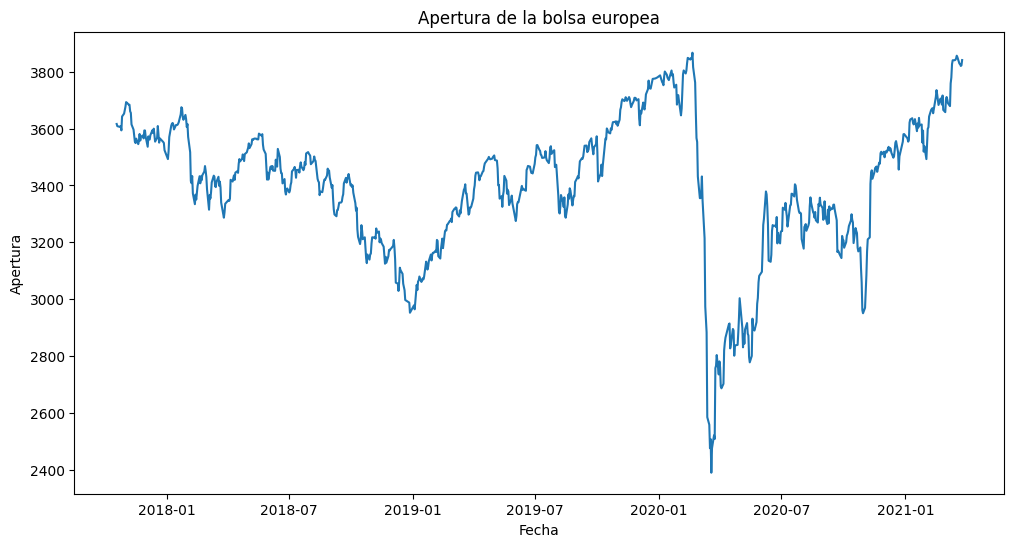

In [141]:
euro_open = euro[['Open']].copy() # seleccionamos la columna de apertura

# Visualización de los datos
# =====================================================================
display(euro_open) # versión tabular

plt.figure(figsize=(12, 6)) # versión gráfica
plt.plot(euro_open['Open'])
plt.title('Apertura de la bolsa europea'), plt.xlabel('Fecha'), plt.ylabel('Apertura')
plt.savefig('../data/img/euro_open.png')
plt.show()

## 2. Análisis del DataFrame

En este apartado, realizaremos un análisis de la serie temporal dividiendo sus componenetes para establecer si natrualeza de la serie. También se hará un análisis de la autocorrelación para ver si la serie es estacionaria o no y un análisis de la autocorrelación (ACF) y autocorrelación parcial (PACF) para obtener más información sobre el comportamiento de la serie temporal.

### 2.1 Descomposición de la serie temporal

Recordemos que la descomposición de una serie temporal es una técnica que nos permite descomponer la serie en sus componentes. Estos componentes son la tendencia, la estacionalidad y los residuos. Estos componentes nos permiten ver la naturaleza de la serie temporal.

**Conclusión:**
- Tras la descomposición de la serie temporal en un periodo de unos 4 años, se puede observar las tendencia ascendente del valor de las acciones de la bolsa europea. Esto concuerda con la naturaleza del mercado de valores pues por lo general, el valor de las acciones de la bolsa tiende a subir con el tiempo. Por tanto, la tendencia de la serie temporal es ascendente a pesar de que durante la mitad de 2020 el valor de las acciones bajó pero esto se debe a la pandemia del COVID-19.

- Con respecto a la componente estacional se puede ver claramente que la serie temporal se repite más o menos cada 1 o 2 meses. Esto se debe a que el mercado de valores tiene un comportamiento cíclico, es decir, hay meses en los que el valor de las acciones sube y otros meses en los que el valor de las acciones baja.

- Finalmente, aboradando el tema de los residuos tanto aditivos como multiplicativos, excluyendo el periodo de la pandemia, se puede observar que los residuos son más o menos constantes. Esto se debe a que el mercado de valores tiene un comportamiento aletorio y se mantienen más o menos constantes a lo largo del tiempo.

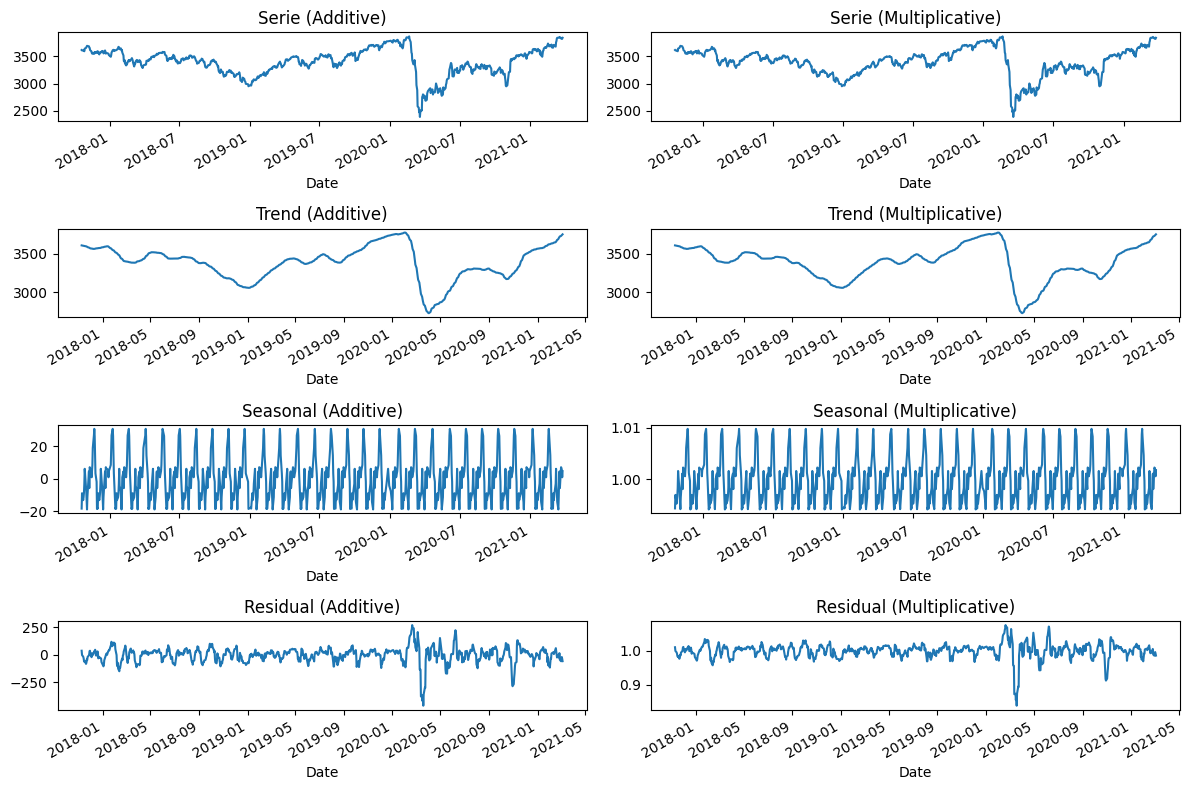

In [142]:
# Descomposición de la serie temporal
# =====================================================================

# Configuración de la figura
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 8))

# Aditiva
result_add = seasonal_decompose(euro_open, model='additive', period=30)
result_add.observed.plot(ax=axes[0, 0], title='Serie (Additive)')
result_add.trend.plot(ax=axes[1, 0], title='Trend (Additive)')
result_add.seasonal.plot(ax=axes[2, 0], title='Seasonal (Additive)')
result_add.resid.plot(ax=axes[3, 0], title='Residual (Additive)')

# Multiplicativa
result_mul = seasonal_decompose(euro_open, model='multiplicative', period=30)
result_mul.observed.plot(ax=axes[0, 1], title='Serie (Multiplicative)')
result_mul.trend.plot(ax=axes[1, 1], title='Trend (Multiplicative)')
result_mul.seasonal.plot(ax=axes[2, 1], title='Seasonal (Multiplicative)')
result_mul.resid.plot(ax=axes[3, 1], title='Residual (Multiplicative)')

# Plot
plt.tight_layout()
plt.show()

### 2.2 Prueba de Dickey-Fuller

La prueba de Dickey-Fuller es una prueba estadística que nos permite comprobar si una serie temporal es estacionaria o no. Para ello, se establece una hipótesis nula y una hipótesis alternativa. La hipótesis nula es que la serie temporal no es estacionaria y la hipótesis alternativa es que la serie temporal es estacionaria. Si el p-valor es mayor que 0.05, se acepta la hipótesis nula y por tanto, se asegura que la serie temporal no es estacionaria. Si el p-valor es menor que 0.05, se rechaza la hipótesis nula y por tanto, se sugiere que la serie temporal es estacionaria.

- **Prueba de Dickey-Fuller para la serie temporal original:**

Como podemos observar, tras la prueba de dickey-fuller, la serie no se puede decir que es estacionaria. Esto lo podemos deducir del valor del estadístico de prueba (ADF estadístico) y el p-valor junto con la comparación de estos valores con los valores críticos. En este caso, el valor del estadístico de prueba es negativo (-2.8108104298808287) lo que a un primer vistazo podría engañar a alguien que la serie si es estacionaria, sin embargo, es mayor que los valores críticos en diferentes niveles de significación (5%, 1%) y además, el valor p es alto (0.05674609044132568), lo que indica que no podemos rechazar la hipótesis nula de que la serie no es estacionaria.

En resumen, la serie temporal no es estacionaria según los resultados de la prueba de Dickey-Fuller.

In [143]:
# Prueba de dickey-fuller
# =====================================================================
sts.adfuller(euro_open.Open) # p-value > 0.05, no se puede rechazar la hipótesis nula de que la serie temporal no es estacionaria

(-2.8108104298808265,
 0.056746090441326016,
 9,
 850,
 {'1%': -3.438066656679015,
  '5%': -2.8649462783472424,
  '10%': -2.5685837702422147},
 8373.592279278542)

- **Prueba de Dickey-Fuller para la serie temporal de los retornos:**

Debido a la no estacionalidad de los valores de la serie, probamos a hacer su integración para representar la serie de una manera de variación porcentual con respecto a los días anteriores, lo cual puede dar un análisis más completo y para ver si podemos conseguir por lo menos que esta parte sea estacionaria para poder hacer un mejor estudio de la serie, pues la estacionalidad de una serie (media y desviación típica constantes) hará que podamos hacer un mejor análisis de esta, pues existirá una relación directa (autocorrelación, dependencia) entre los elementos futuros de la serie con los elementos pasados, además de que los errores son prácticamente cte. y, por tanto, previsibles.

Tras la prueba de Dickey-Fuller con los retornos de la serie, los resultados sugieren que es estacionaria, ya que el p valor es menor que 0.05 (3.143184515152134e-16) y el estadístico de prueba es negativo y menor que los valores críticos en todos los niveles de significación. Por tanto, podemos decir que la serie de los retornos es estacionaria.

In [144]:
# Calculamos los retornos del dataset y hacemos también la prueba de dickey-fuller
# =====================================================================
euro_open['Returns'] = euro_open.Open.pct_change(1).mul(100) # returns in percentage (variación porcentual con respecto al mes anterior)
sts.adfuller(euro_open.Returns[1:]) # p-value < 0.05, se rechaza la hipótesis nula de que la serie temporal no es estacionaria

(-9.516698328996107,
 3.1431845151522483e-16,
 8,
 850,
 {'1%': -3.438066656679015,
  '5%': -2.8649462783472424,
  '10%': -2.5685837702422147},
 2585.3006974028144)

Date
2017-10-19         NaN
2017-10-20   -0.214019
2017-10-23   -0.056530
2017-10-24   -0.001943
2017-10-25    0.065993
                ...   
2021-03-22   -0.595860
2021-03-23   -0.029250
2021-03-24   -0.176615
2021-03-25    0.047374
2021-03-26    0.493641
Name: Returns, Length: 860, dtype: float64

<Axes: title={'center': ' Retornos de los valores de la bolsa europea'}, xlabel='Date', ylabel='Returns'>

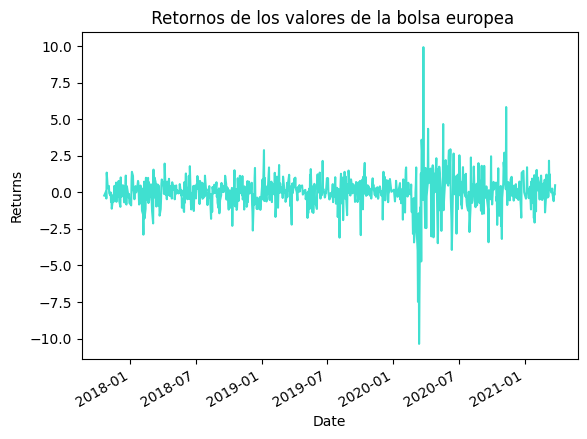

In [145]:
# Visualización de los retornos de los retornos
# =====================================================================
display(euro_open.Returns) # versión tabular
euro_open.Returns.plot(color='#40E0D0', title=' Retornos de los valores de la bolsa europea', xlabel=euro_open.index.name, ylabel=euro_open.Returns.name) # versión gráfica

### 2.3 Análisis de la autocorrelación

En ambos casos, tanto para la autocorrelación como para la autocorrelación parcial, optaremos por seleccionar un rezago temporal (lag) de 30 unidades, dado que al abordar el precio de las acciones de la bolsa diaría, la consideración de un período de análisis de 30 días (1 mes) puede conferir mayor representatividad a la serie temporal.

- **ACF y PACF para la serie temporal original:**

Mediante el análisis de autocorrelación de la serie de acciones, se aprecia que, a nivel global (ACF), la influencia preponderante en acciones de un día específico proviene del día inmediatamente anterior. 

Por otro lado, en el análisis a nivel parcial (PACF), revela que la serie se ve afectada en mayor medida por el día anterior y por el segundo y tercer día anteriores, en menor medida.

Es decir, el ACF y el PACF indican que el valor del euro en un día determinado se encuentra influido por los 3 días que le preceden.

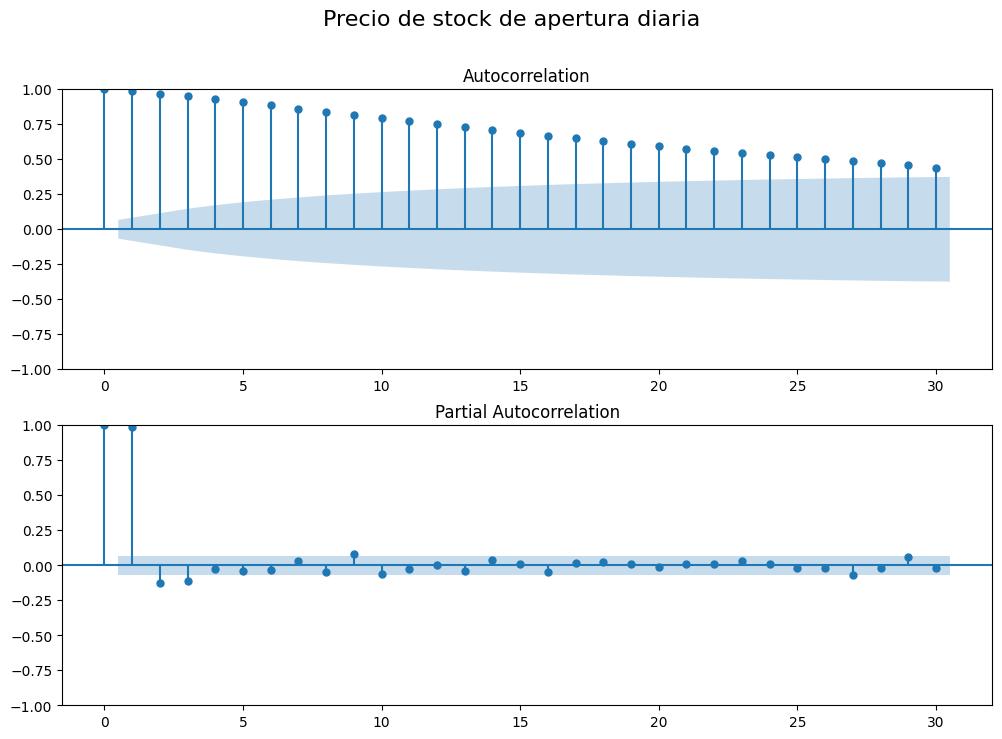

In [146]:
# Análisis de la autocorrelación de los pasajeros mensuales
# =====================================================================
def plot_acf_pacf(df, lags, title):
    fig, ax = plt.subplots(2,1,figsize=(12,8))
    plt.suptitle(title, fontsize=16)
    sgt.plot_acf(df, lags = lags, ax=ax[0]) # autocorrelación
    sgt.plot_pacf(df, lags = lags, ax=ax[1]) # autocorrelación parcial
    plt.show()


plot_acf_pacf(euro_open.Open,lags=30, title='Precio de stock de apertura diaria')

- **ACF y PACF para la serie temporal de los retornos:**

El análisis de autocorrelación para los retornos muestra algo similar al de la serie original, indicando que la serie se ve influencia por los valores de los 2 días anteriores y al 8 día anterior, es decir, el día anterior de la semana anterior. Esto es igual tanto para el ACF como para el PACF de los retornos de las acciones del euro.

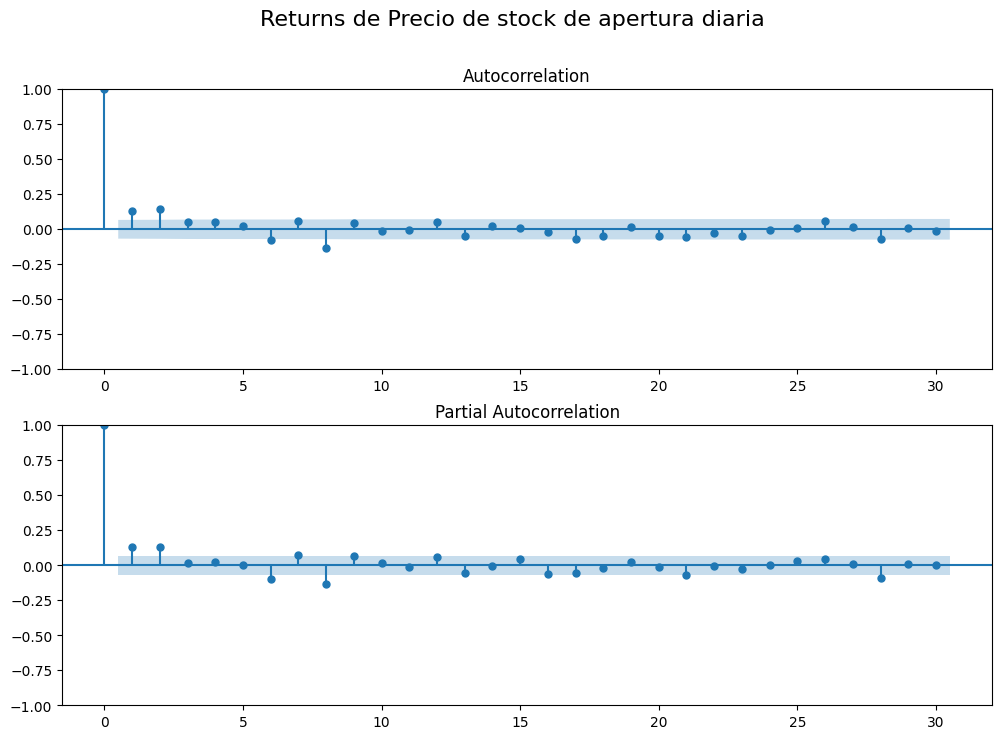

In [147]:
# Análisis de la autocorrelación del retorno pasajeros mensuales
# =====================================================================
plot_acf_pacf(euro_open.Returns[1:],lags=30, title='Returns de Precio de stock de apertura diaria')

Estas visualizaciones de la tendencia nos permitirán hacer una mejor elección de que predictor funcionará mejor pues tras estas visualizaciones podemos confirmar lo establecido en la descomposición de la serie temporal, es decir, que la serie temporal tiene una tendencia ligeramente ascendente. Es decir una tendencia ccontinusita ligeramente al alza, por lo que un predictor que nos prediga una tendencia ascendente tal cual o descendente no será muy fiable, por lo que se descartará. También se puede observar que los retornos mantienen la tendencia estable mostrando la estacionalidad de la serie, apoyando así la hipótesis de que los retornos son estacionarios.	

La exposición de los resultados de las tendencias tanto para la serie original como para sus retornos ofrece una visión reveladora de la estructura de la serie temporal. La observación de la estacionalidad en los retornos y las tendencias trazadas proporciona información valiosa para la selección de predictores efectivos.

En resumen, el análisis visual de las tendencias ofrece una base sólida para la toma de decisiones informada en la selección de predictores, permitiendo descartar aquellos que no se alinean con la estructura subyacente de la serie temporal.

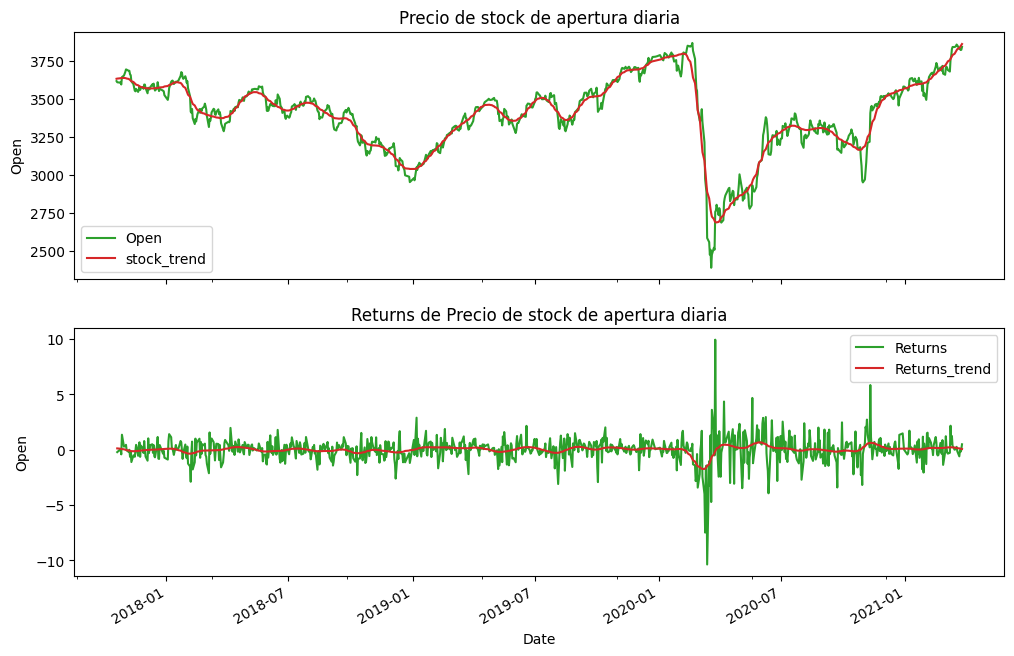

In [148]:
# Establecemos la tendencia de la serie temporal tanto para las ventas como para sus retornos
# =====================================================================
circular, tendencia = hpfilter(euro_open.Open, lamb=1600)
euro_open['stock_trend'] = tendencia

circularR, tendenciaR = hpfilter(euro_open.Returns[1:], lamb=1600)
euro_open['Returns_trend'] = tendenciaR

# Visualización de los datos
# =====================================================================
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
euro_open[['Open','stock_trend']].plot(color=['tab:green','tab:red'], xlabel=euro_open.index.name, ylabel=euro_open.Open.name, title='Precio de stock de apertura diaria', ax=axs[0]) # versión gráfica
euro_open[['Returns','Returns_trend']].plot(color=['tab:green','tab:red'], xlabel=euro_open.index.name, ylabel=euro_open.Open.name, title='Returns de Precio de stock de apertura diaria', ax=axs[1]) # versión gráfica
plt.show()

## 3. Métodos de Predicción

En este apartado, realizaremos un análisis de los métodos de predicción vistos en la asignatura. Para ello, usaremos la librería ``statsmodels`` que nos permite realizar dichos modelos predictivos. Los modelos predictivos que usaremos son los siguientes:

- **AR, MA, ARMA**

- **ARIMA**

- **SARIMA**

- **SARIMAX**

Antes de realizar los modelos predictivos, dividimos el dataset en train y test. Puesto que contamos con 860 valores, usaremos prácticamente la totalidad de los datos para entrenar los modelos y los últimos 10 valores para testear los modelos. Solo usaremos 10 valores para testear los modelos pues queremos ver si los modelos predicen bien los valores a un corto plazo, esto se debe a que hacer predicciones sobre una serie temporal de caracter pseudo-aleatorio es muy difícil y prácticamente imposible hoy en día.

In [149]:
# División de los datos en train y test
# =====================================================================
size = len(euro_open) - 10
wd_train, wd_test = euro_open.iloc[:size], euro_open.iloc[size:]

### 3.1 AR, MA, ARMA

Previo a la realización de los modelos más complejos, se realizarán los modelos AR, MA y ARMA para poder usarlos como base para los modelos ARIMA, SARIMA y SARIMAX y elegir sus hiperparámetros. Para ello, usaremos la primera serie estacionaria en nuestro caso, la primera diferencia de la serie temporal original de los valores de la bolsa europea.

#### 3.1.1 AR

- El modelo AR, se trata de un modelo autorregresivo, es decir, un modelo que predice el valor futuro de una variable en función de sus valores pasados. En este caso, el modelo AR se basa en la regresión lineal de la variable dependiente (y) con respecto a sus valores pasados (y(t-1), y(t-2), ...), es decir, la variable dependiente se regresa a sí misma.

In [150]:
# AR
# =====================================================================

# AIC
ARfitAIC = ar_model.ar_select_order(wd_train.Returns[1:],17, ic="aic", glob=True)
orden=ARfitAIC.ar_lags # orden del modelo
print(f'Lag: {orden}')

Lag: [1, 2, 4, 6, 7, 8, 9, 12, 13, 15, 16, 17]


- Una vez elegidos los lags de interés. Hacemos un estudio del LLF (Log Likelihood Function), el AIC (Akaike Information Criterion), BIC (Bayesian Information Criterion) y el error paara hacer una preselcción de los 3 o 4 mejores lags.

In [151]:
testGeneral = [1, 2, 4, 6, 7, 8, 9, 12, 13, 15, 16, 17] # elegimos los lags que nos interesan

ModelArima = {}

llf_list = []
aic_list = []
bic_list = []
error_list = []

for x in testGeneral:
  model_ar = ARIMA(wd_train.Returns[1:], order=(x,0,0))
  results_ar = model_ar.fit()
  results_arfore = results_ar.forecast(steps=len(wd_test.Returns))
  ModelArima["AR("+str(x)+")"] = results_arfore

  error = mean_squared_error(wd_test.Returns, results_arfore)

  llf_list.append(results_ar.llf)
  aic_list.append(results_ar.aic)
  bic_list.append(results_ar.bic)
  error_list.append(error)

#########LO HEMOS HECHO CON PLOTS PUES SI NO SALIAN LOS VALORES ENTREMEDIAS DE LOS AVISOS DEL OUTPUT DE ESTA CELDA Y NO SE VEIA MUY CLATO PARA HACER UN ANALISIS DE LOS RESULTADOS#########

# LLF -> Log Likelihood Function, represents the log of the likelihood function so the higher the LLF the better the model is
print("LLF")
for i in range(len(testGeneral)):
  print(f'AR({testGeneral[i]}): {llf_list[i]}')
  
print()

# AIC -> represents the tradeoff between the goodness of fit of the model and the simplicity of the model so the lowest AIC is chosen the better the model is
print("AIC")
for i in range(len(testGeneral)):
  print(f'AR({testGeneral[i]}): {aic_list[i]}')
  
print()

# BIC -> is a criterion for model selection among a finite set of models; the model with the lowest BIC is preferred
print("BIC")
for i in range(len(testGeneral)):
  print(f'AR({testGeneral[i]}): {bic_list[i]}')
  
print()

# Error -> the lower the error the better the model is
print("Error")
for i in range(len(testGeneral)):
  print(f'AR({testGeneral[i]}): {error_list[i]}')
  
print()

LLF
AR(1): -1321.2010387048958
AR(2): -1313.7278870750933
AR(4): -1313.2884362635837
AR(6): -1309.2189389783448
AR(7): -1306.791272127102
AR(8): -1298.8475086043704
AR(9): -1296.6887655766664
AR(12): -1295.0111060954732
AR(13): -1293.5949146140354
AR(15): -1292.645916238762
AR(16): -1290.738261488973
AR(17): -1289.6535823810739

AIC
AR(1): 2648.4020774097917
AR(2): 2635.4557741501867
AR(4): 2638.5768725271673
AR(6): 2634.4378779566896
AR(7): 2631.582544254204
AR(8): 2617.695017208741
AR(9): 2615.3775311533327
AR(12): 2618.0222121909464
AR(13): 2617.1898292280707
AR(15): 2619.291832477524
AR(16): 2617.476522977946
AR(17): 2617.3071647621477

BIC
AR(1): 2662.6342549687256
AR(2): 2654.432010895432
AR(4): 2667.0412276450356
AR(6): 2672.3903514471804
AR(7): 2674.2790769310063
AR(8): 2665.1356090718546
AR(9): 2667.5621822027574
AR(12): 2684.4390407993055
AR(13): 2688.350717022741
AR(15): 2699.940838644817
AR(16): 2702.8695883315504
AR(17): 2707.444289302063

Error
AR(1): 0.0738445424659909
A

- Basándonos en estos valores, podemos ver que los mejores modelos son los de AR(1), AR(2) y AR(8) pues son los que tienen menor error, AIC, BIC y mayor LLF. Hagamos una visualización de los valores predichos por estos modelos para ver cuál de ellos se ajusta mejor a la serie temporal.

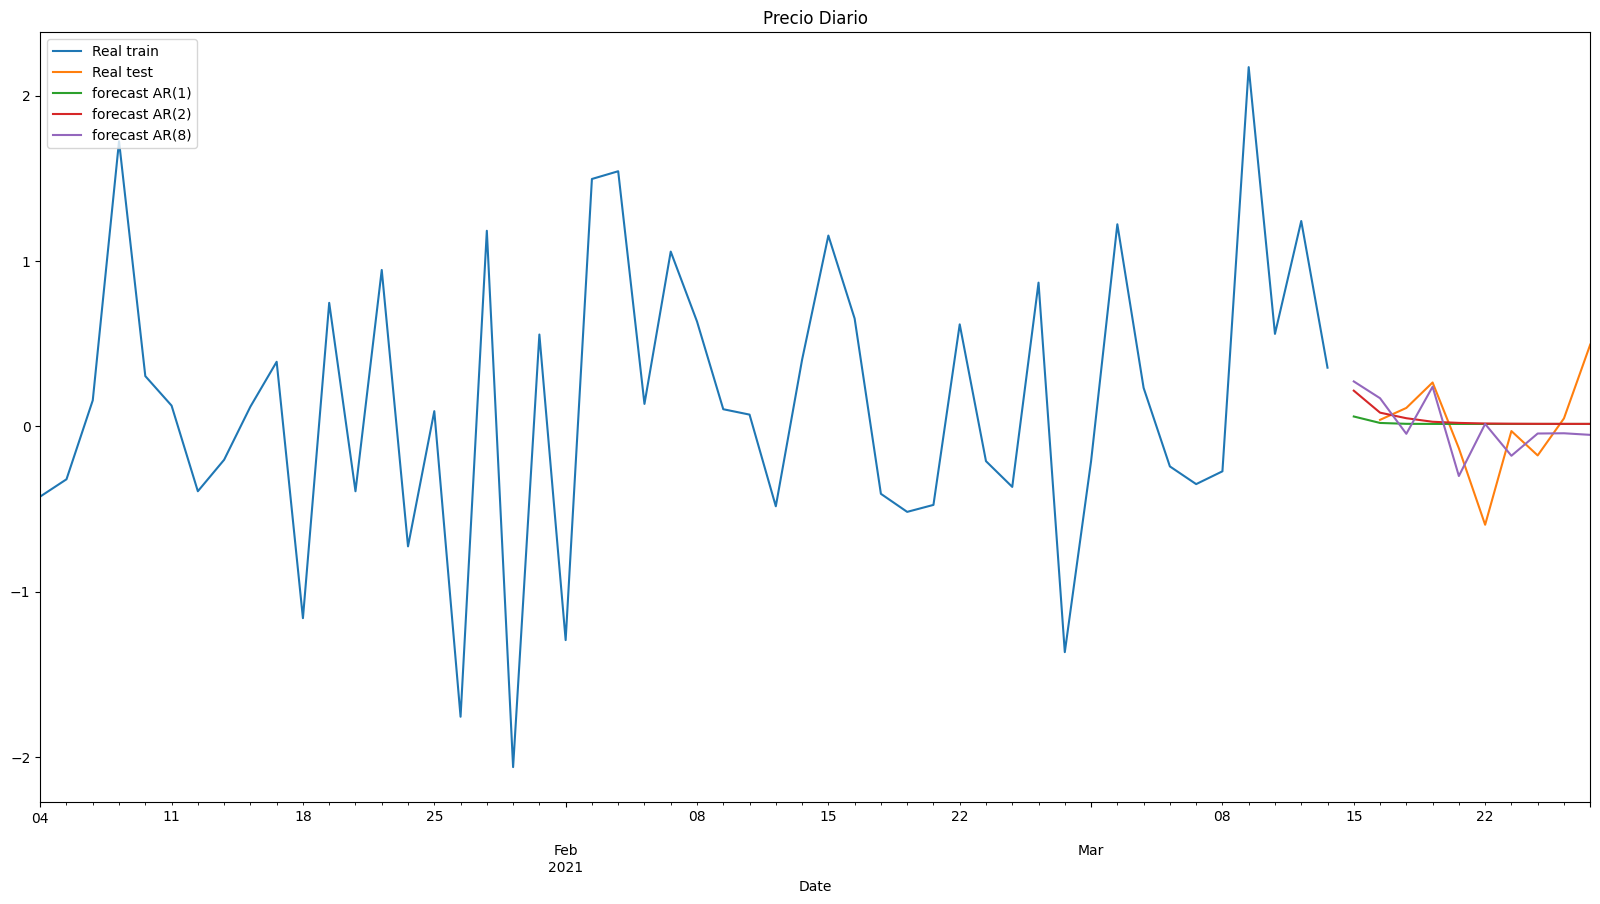

In [152]:
testGeneral = [1,2,8] # elegimos los lags que nos interesan con menor LLF, AIC, BIC y error

wd_train.Returns[800:].plot(figsize=(20,10), title = "Precio Diario", label='Real train') # hacemos el plot de los datos de entrenamiento ajustado para que se vea mejor
wd_test.Returns[1:].plot(label='Real test')

for x in testGeneral:
   ModelArima["AR("+str(x)+")"].index=wd_test.Returns.index
   ModelArima["AR("+str(x)+")"].plot(label='forecast AR('+str(x)+")")
plt.legend(loc="upper left")
plt.show()

- Elección del modelo **AR(8)** para la predicción de los valores de las acciones de la bolsa europea. Como podemos observar, el modelo AR(8) es el que mejor se ajusta a la serie temporal pues es el que más se acerca a los valores reales de la serie. 

Por tanto, elegimos el modelo AR(8) para la predicción de los valores de las acciones de la bolsa europea.

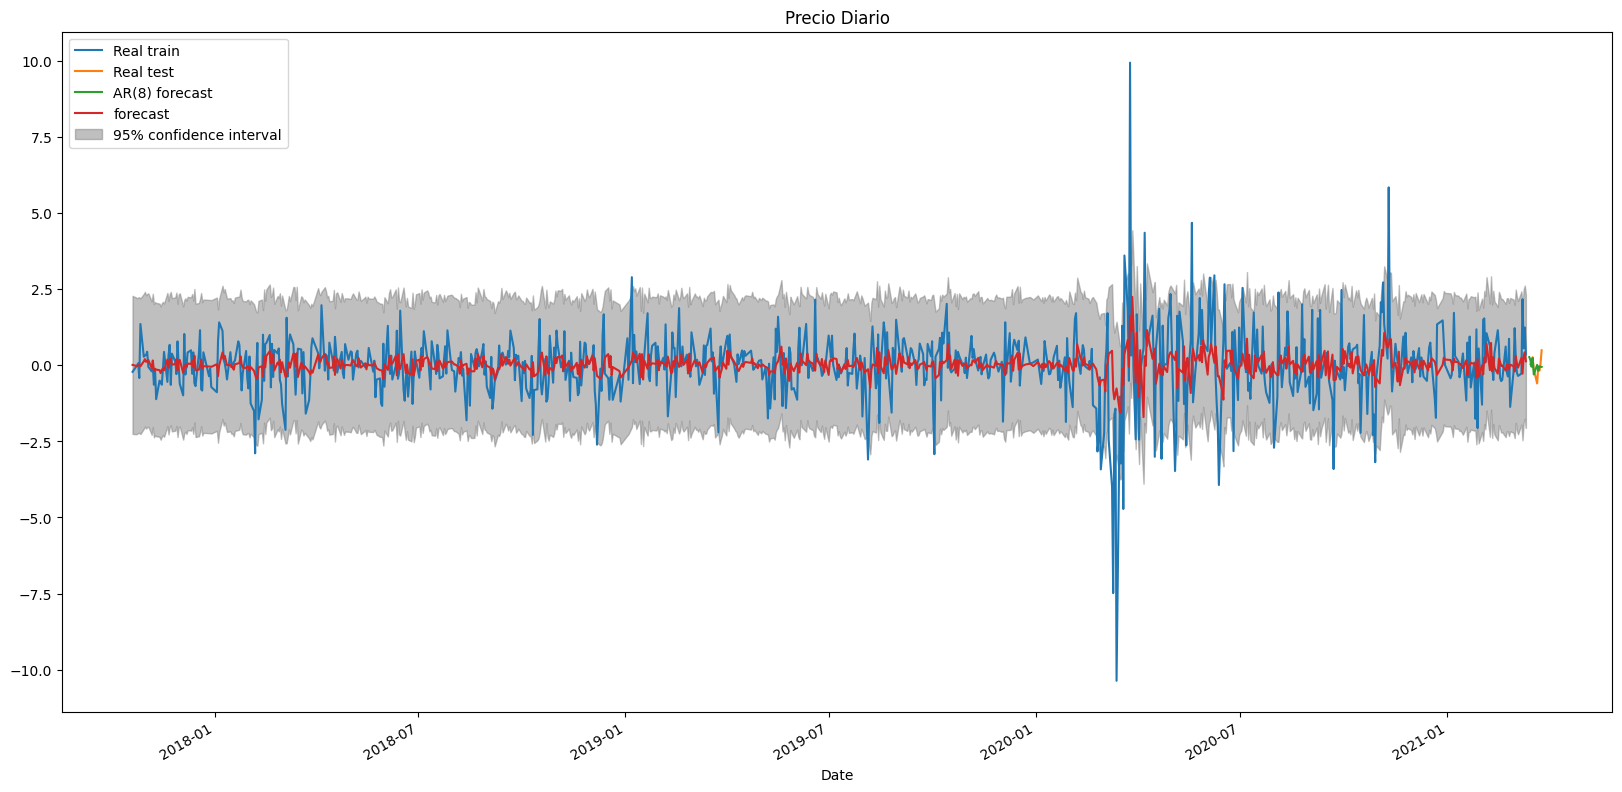

In [153]:
# AR(8)
# =====================================================================

# Plot adjusts
fig, ax = plt.subplots()
ax = wd_train.Returns[1:].plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real train')
ax = wd_test.Returns[1:].plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real test')

# AR(8)
model_ar = ARIMA(wd_train.Returns[1:], order=(8,0,0)) # elegimos el modelo con menor LLF, AIC, BIC y error, en este caso AR(8)
results_ar = model_ar.fit()
results_arfore = results_ar.forecast(steps=10)
results_arfore.index=wd_test.Returns.index

# Plot
ax = results_arfore.plot(ax=ax, label='AR(8) forecast')
plot_predict(results_ar, dynamic=False,ax=ax)
plt.legend(loc="upper left")
plt.show()

- Como podemos observar, el modelo AR(8) se ajusta de manera aceptable a los valores reales de la serie, pues el error es bastante bajo con respecto al resto de modelos. Por lo que tanto teóricamente como visualmente, podemos decir que el modelo AR(8) es un buen modelo para predecir los valores de la serie.

#### 3.1.2 MA

- El modelo MA, se trata de un modelo de media móvil, es decir, un modelo que predice el valor futuro de una variable en función de los errores pasados. En este caso, el modelo MA se basa en la regresión lineal de la variable dependiente (y) con respecto a sus errores pasados (e(t-1), e(t-2), ...), es decir, la variable dependiente se regresa a sus errores pasados.

In [154]:
# Latent Likelihood Ratio
from scipy.stats.distributions import chi2
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

In [155]:
# MA
# =====================================================================
from sklearn.metrics import mean_squared_error

ModelArima=dict()
results_maprey=None

llf_list = []
aic_list = []
bic_list = []
error_list = []

testGeneral = range(25)

for x in testGeneral:
  model_ma = ARIMA(wd_train.Returns[1:], order=(0,0,x))
  results_ma = model_ma.fit()
  results_mafore = results_ma.forecast(steps=len(wd_test.Returns))
  ModelArima["MA("+str(x)+")"] = results_mafore

  error = None
  if results_maprey is not None:
    error = str(LLR_test(results_maprey, results_ma))

  results_maprey=results_ma
  
  llf_list.append(results_ma.llf)
  aic_list.append(results_ma.aic)
  bic_list.append(results_ma.bic)
  error_list.append(error)

#########LO HEMOS HECHO CON PLOTS PUES SI NO ME SALIAN LOS VALORES ENTREMEDIAS DE LOS AVISOS DEL OUTPUT DE ESTA CELDA Y NO SE VEIA MUY CLATO PARA HACER UN ANALISIS DE LOS RESULTADOS#########

# LLF -> Log Likelihood Function, represents the log of the likelihood function so the higher the LLF the better the model is
print("LLF")
for i in range(len(testGeneral)):
  print(f'MA({testGeneral[i]}): {llf_list[i]}')
  
print()

# AIC -> represents the tradeoff between the goodness of fit of the model and the simplicity of the model so the lowest AIC is chosen the better the model is
print("AIC")
for i in range(len(testGeneral)):
  print(f'MA({testGeneral[i]}): {aic_list[i]}')
  
print()

# BIC -> is a criterion for model selection among a finite set of models; the model with the lowest BIC is preferred
print("BIC")
for i in range(len(testGeneral)):
  print(f'MA({testGeneral[i]}): {bic_list[i]}')
  
print()

# LLR test p-vaue -> the lower the error the better the model is
print("LLR test p-vaue")
for i in range(len(testGeneral)):
  print(f'MA({testGeneral[i]}): {error_list[i]}')

LLF
MA(0): -1328.72959725527
MA(1): -1322.8160331705317
MA(2): -1315.145427147341
MA(3): -1314.5397146485652
MA(4): -1312.194506577086
MA(5): -1312.0848519518033
MA(6): -1310.6299879647486
MA(7): -1307.767345882065
MA(8): -1296.7370408829386
MA(9): -1296.0675989579581
MA(10): -1295.6764271239576
MA(11): -1295.6646441513765
MA(12): -1294.7634176477322
MA(13): -1293.9097152926067
MA(14): -1293.7002657999021
MA(15): -1293.686892905661
MA(16): -1293.608510541525
MA(17): -1290.7798392520872
MA(18): -1290.2279247847223
MA(19): -1289.246184550062
MA(20): -1288.7269060829894
MA(21): -1288.6182126736012
MA(22): -1287.989524431602
MA(23): -1287.4434553672872
MA(24): -1286.4160243651022

AIC
MA(0): 2661.45919451054
MA(1): 2651.6320663410634
MA(2): 2638.290854294682
MA(3): 2639.0794292971304
MA(4): 2636.389013154172
MA(5): 2638.1697039036067
MA(6): 2637.259975929497
MA(7): 2633.53469176413
MA(8): 2613.474081765877
MA(9): 2614.1351979159163
MA(10): 2615.3528542479153
MA(11): 2617.329288302753
MA(12

- Basándonos en estos valores, podemos ver que los mejores modelos son los de MA(1-7) pues son los que tienen mejor equilibrio de menor error, AIC, BIC y mayor LLF.

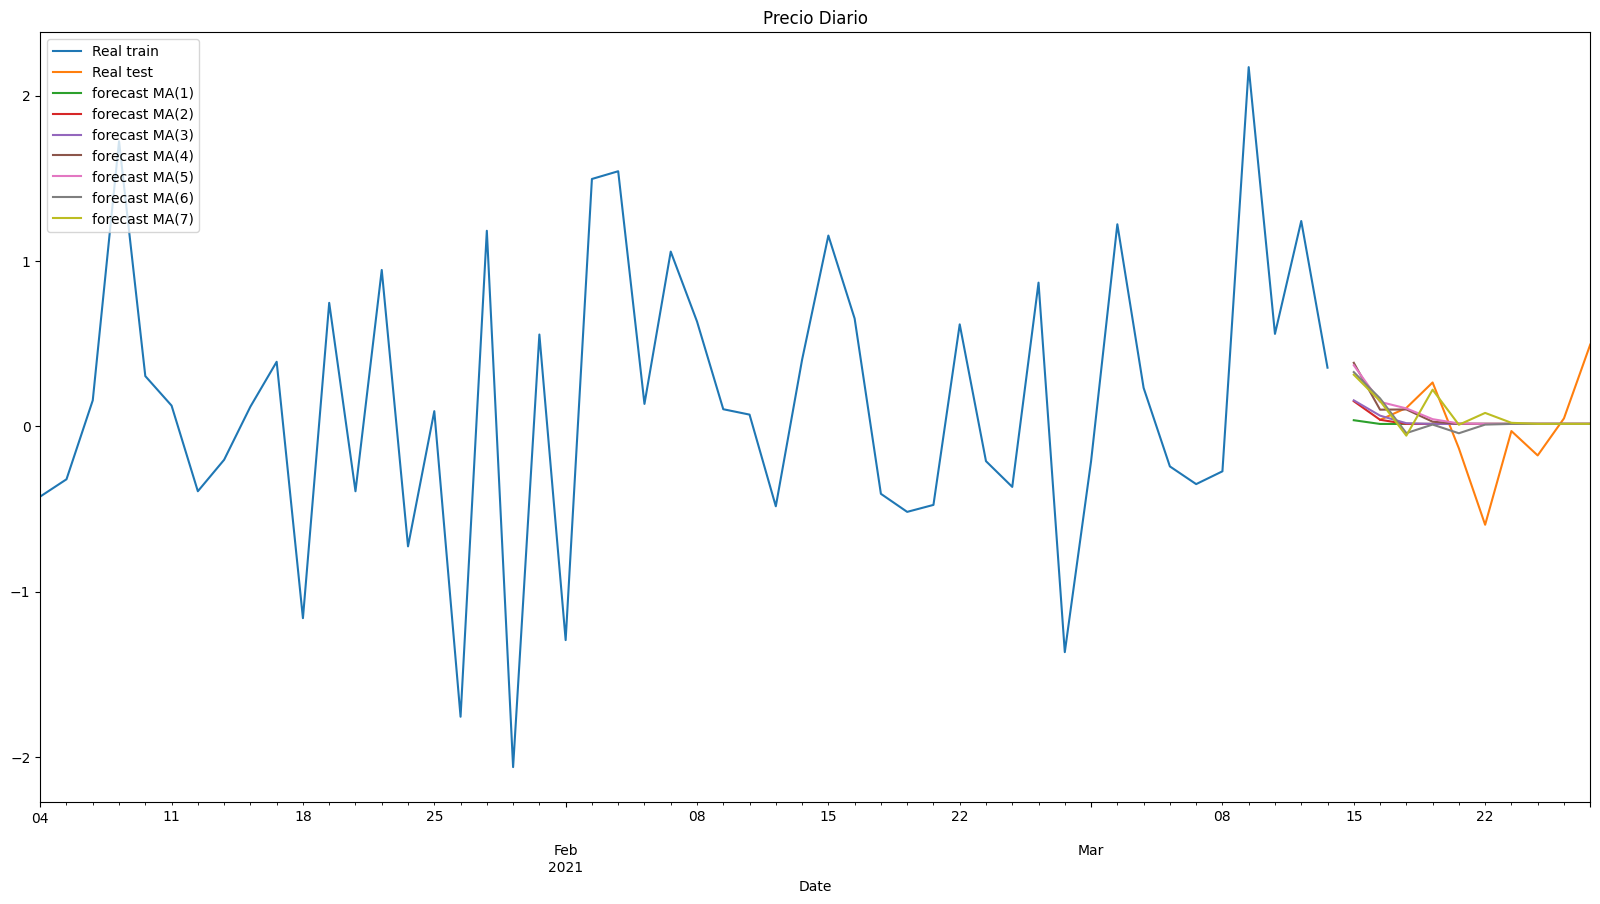

In [156]:
testGeneral = [1,2,3,4,5,6,7] # elegimos los lags que nos interesan con menor LLF, AIC, BIC y error

wd_train.Returns[800:].plot(figsize=(20,10), title = "Precio Diario", label='Real train')
wd_test.Returns[1:].plot(label='Real test')
for x in testGeneral:
   ModelArima["MA("+str(x)+")"].index=wd_test.Returns.index
   ModelArima["MA("+str(x)+")"].plot(label='forecast MA('+str(x)+")")
plt.legend(loc="upper left")
plt.show()

- Tras ver los resultados, vemos que el modelo MA(6) y el modelo MA(7) son los que visualmente se ve mejor y además tiene un LLF alto, menor error, AIC y BIC con respecto a los otros MA aunque mejor el **MA(7)**, por lo que elegiremos este modelo para predecir los valores de la serie.

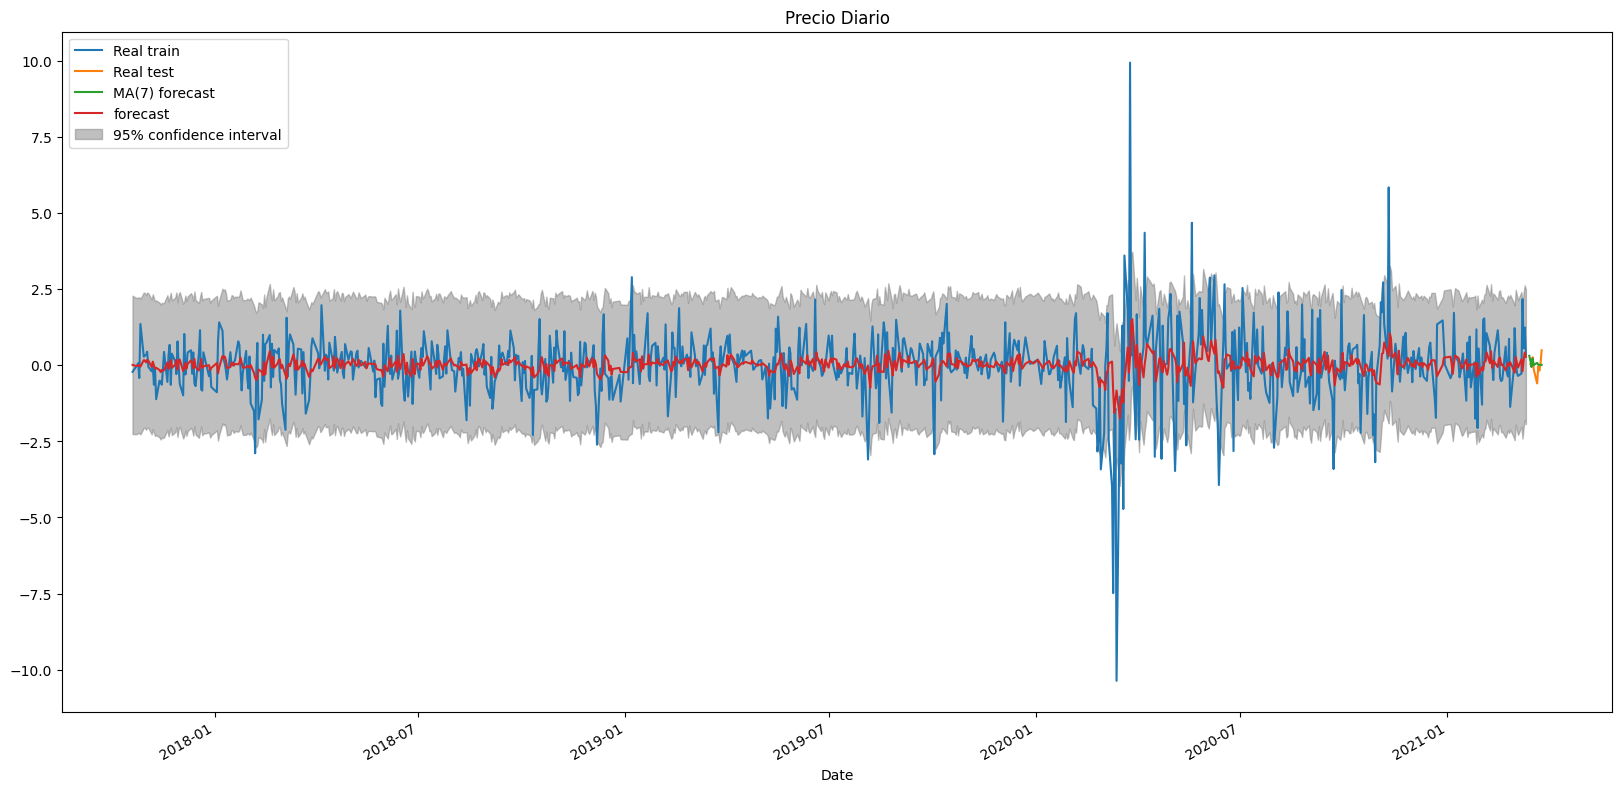

In [157]:
# MA(7)
# =====================================================================

# Plot adjusts
fig, ax = plt.subplots()
ax = wd_train.Returns[1:].plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real train')
ax = wd_test.Returns[1:].plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real test')

model_ma = ARIMA(wd_train.Returns[1:], order=(0,0,7)) # elegimos el modelo con menor LLF, AIC, BIC y error, en este caso MA(7)
results_ma = model_ma.fit()
results_mafore = results_ma.forecast(steps=10)
results_mafore.index=wd_test.Returns.index

# Plot
ax = results_mafore.plot(ax=ax,label='MA(7) forecast')
plot_predict(results_ma, dynamic=False,ax=ax)
plt.legend(loc="upper left")
plt.show()

- Vemos que los aceptables buenos, pues el LLF es alto, el error, AIC y BIC son bastante bajos con respecto a los otros MA, por lo que el modelo de entre los posibles, es el que mejor se ajusta a los valores reales de la serie.

#### 3.1.3 ARMA

- El modelo ARMA, se trata de un modelo autorregresivo de media móvil, es decir, un modelo que predice el valor futuro de una variable en función de sus valores pasados y de los errores pasados. En este caso, el modelo ARMA se basa en la regresión lineal de la variable dependiente (y) con respecto a sus valores pasados (y(t-1), y(t-2), ...) y de sus errores pasados (e(t-1), e(t-2), ...), es decir, la variable dependiente se regresa a sí misma y a sus errores pasados.

Como hemos visto los mejores valores son AR(8) y MA(7), por lo que usaremos estos valores tanto para el modelo ARMA como para el modelo ARIMA. Como hemos integrado la serie una vez para que sea estacionaria, usaremos d=1. Por lo que el modelo ARIMA(8,1,7) será el que usemos para predecir los valores de la serie.

**NOTA:** Aunque en clase se dejo no hacer el modelo ARMA en caso de integrar la serie, sin embargo, se ha decidido hacerlo para ver tener una base de comparación con los modelos posteriores.

In [158]:
# ARMA
# =====================================================================
model_arma = ARIMA(wd_train.Returns[1:], order=(8,0,7)) # elegimos el modelo con mayor LLF y emnor, AIC, BIC y error, en los modelos AR y MA ->(8,7)
results_arma = model_arma.fit() # ajustamos el modelo
sts.adfuller(results_arma.resid) # p-value < 0.05, se rechaza la hipótesis nula de que la serie temporal no es estacionaria

(-29.257470489970526,
 0.0,
 0,
 848,
 {'1%': -3.4380849118778234,
  '5%': -2.86495432618506,
  '10%': -2.5685880571933963},
 2539.6146687304463)

- Puesto que el p-valor es menor que 0.05 y el estadístico de prueba es menor que los valores críticos, podemos decir que la serie es estacionaria. Por tanto, podemos usar el modelo ARMA(8,7) para predecir los valores de la serie.

Finalmente, visualizamos un predict plot del modelo ARMA(8,7) para ver si se ajusta bien a los valores reales de la serie y lo comparamos con los modelos AR(8) y MA(7) para ver cual funciona mejor. 

Como podemos observar, el modelo ARMA(8,7) se ajusta bastante de manera parecida los modelos previos con respecto a los valores reales de la serie. Sin embargo, el modelo AR(8) se ajusta mejor a los valores reales de la serie que el ARMA(8,7) y el MA(7) se ajusta peor a los valores reales de la serie que el ARMA(8,7).

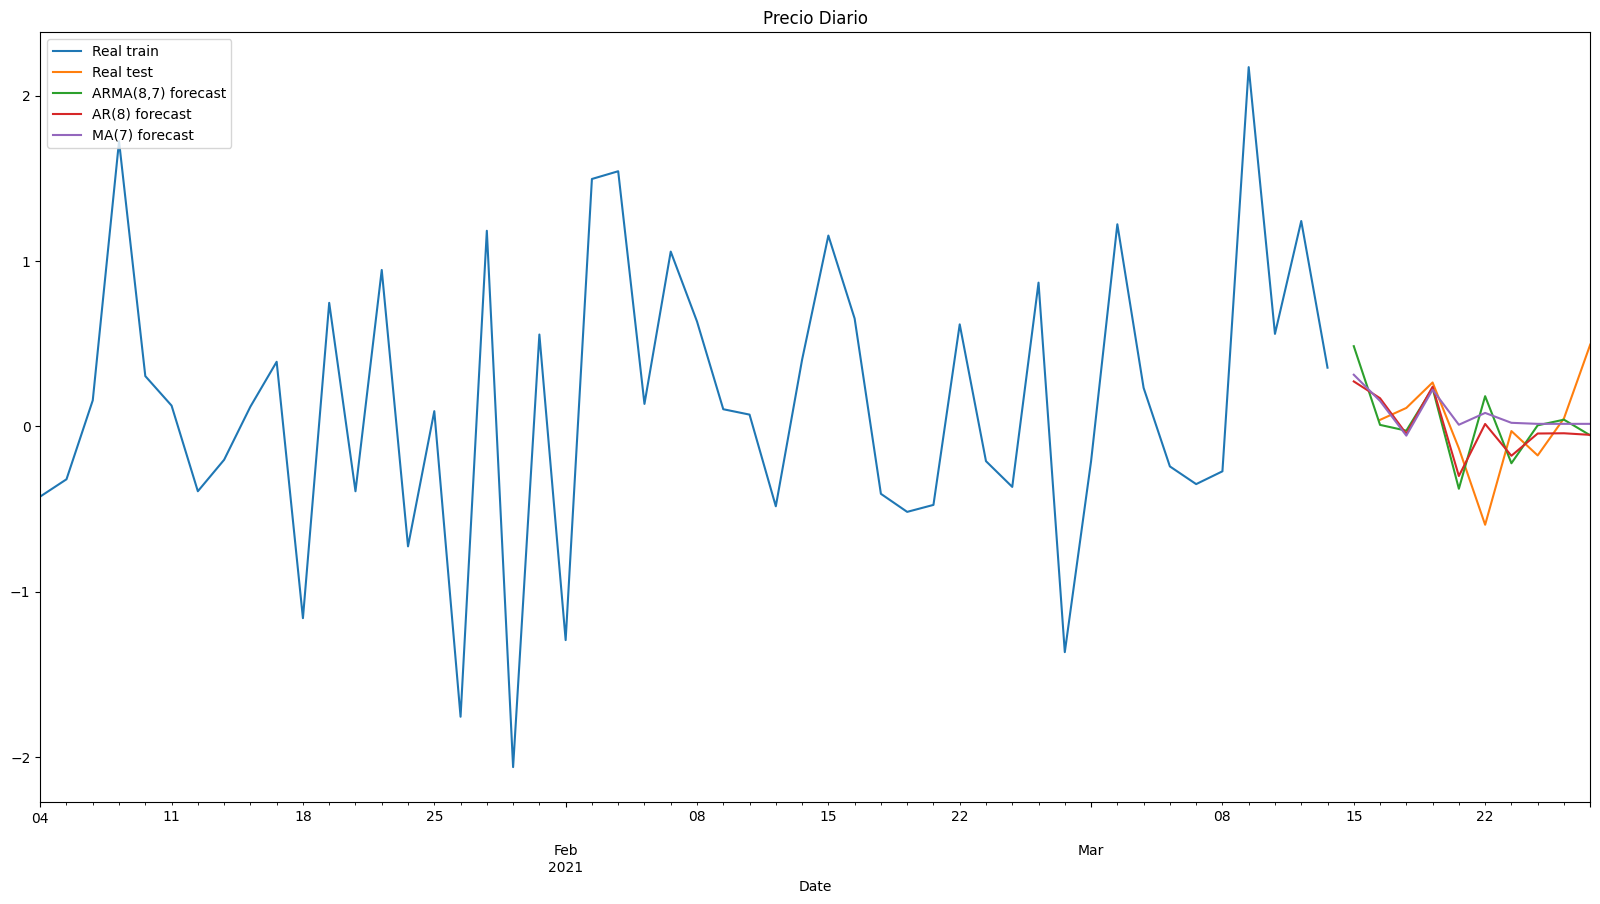

In [159]:
# ARMA(8,7)
# =====================================================================
fig, ax = plt.subplots()
ax = wd_train.Returns[800:].plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real train')
ax = wd_test.Returns[1:].plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real test')

model_arma = ARIMA(wd_train.Returns[1:], order=(8,0,7))
results_arma = model_arma.fit()
results_armafore = results_arma.forecast(steps=10)
results_armafore.index=wd_test.Returns.index

ax = results_armafore.plot(ax=ax,label='ARMA(8,7) forecast')
ax = results_arfore.plot(ax=ax, label='AR(8) forecast')
ax = results_mafore.plot(ax=ax,label='MA(7) forecast')

#plot_predict(results_ma, dynamic=False,ax=ax)
plt.legend(loc="upper left")
plt.show()

### 3.1 ARIMA

Como hemos visto el ARMA(8,7) sobre los retornos se ajusta reltivamente decente a los datos. Puesto que hemos tenido que hacer una diferenciación sobre la serie para poder hacerla estacionaria, vamos a probar a hacer un modelo ARIMA para predecir los valores de la serie de pasajeros y comparar los resultados con el ARMA(8,7) y sobre AR(8) (que hasta ahora es el mejor modelo) sobre la serie original.

Para los hiperparámetros del modelo ARIMA, vamos a usar los mismos que en el modelo ARMA(8,7), es decir, AR(8) y MA(7) y como hemos tenido que hacer una diferenciación sobre la serie, usaremos una diferenciación de orden 1.

In [160]:
# ARIMA
# =====================================================================
model_arima = ARIMA(wd_train.Open, order=(8,1,7))
results_arima = model_arima.fit()
sts.adfuller(results_arima.resid)

(-107.0280174757067,
 0.0,
 0,
 849,
 {'1%': -3.4380757734945697,
  '5%': -2.8649502975181314,
  '10%': -2.5685859111876925},
 8263.951433181752)

- Como podemos observar, tras el test de Dickey-Fuller, la serie usando el modelo ARIMA es estacionaria, pues el p-valor es menor que 0.05 y el estadístico de prueba es menor que los valores críticos en los diferentes niveles de significación. Ahora, vamos a ver si podemos mejorar el modelo ARMA(8,7) y el AR(8).

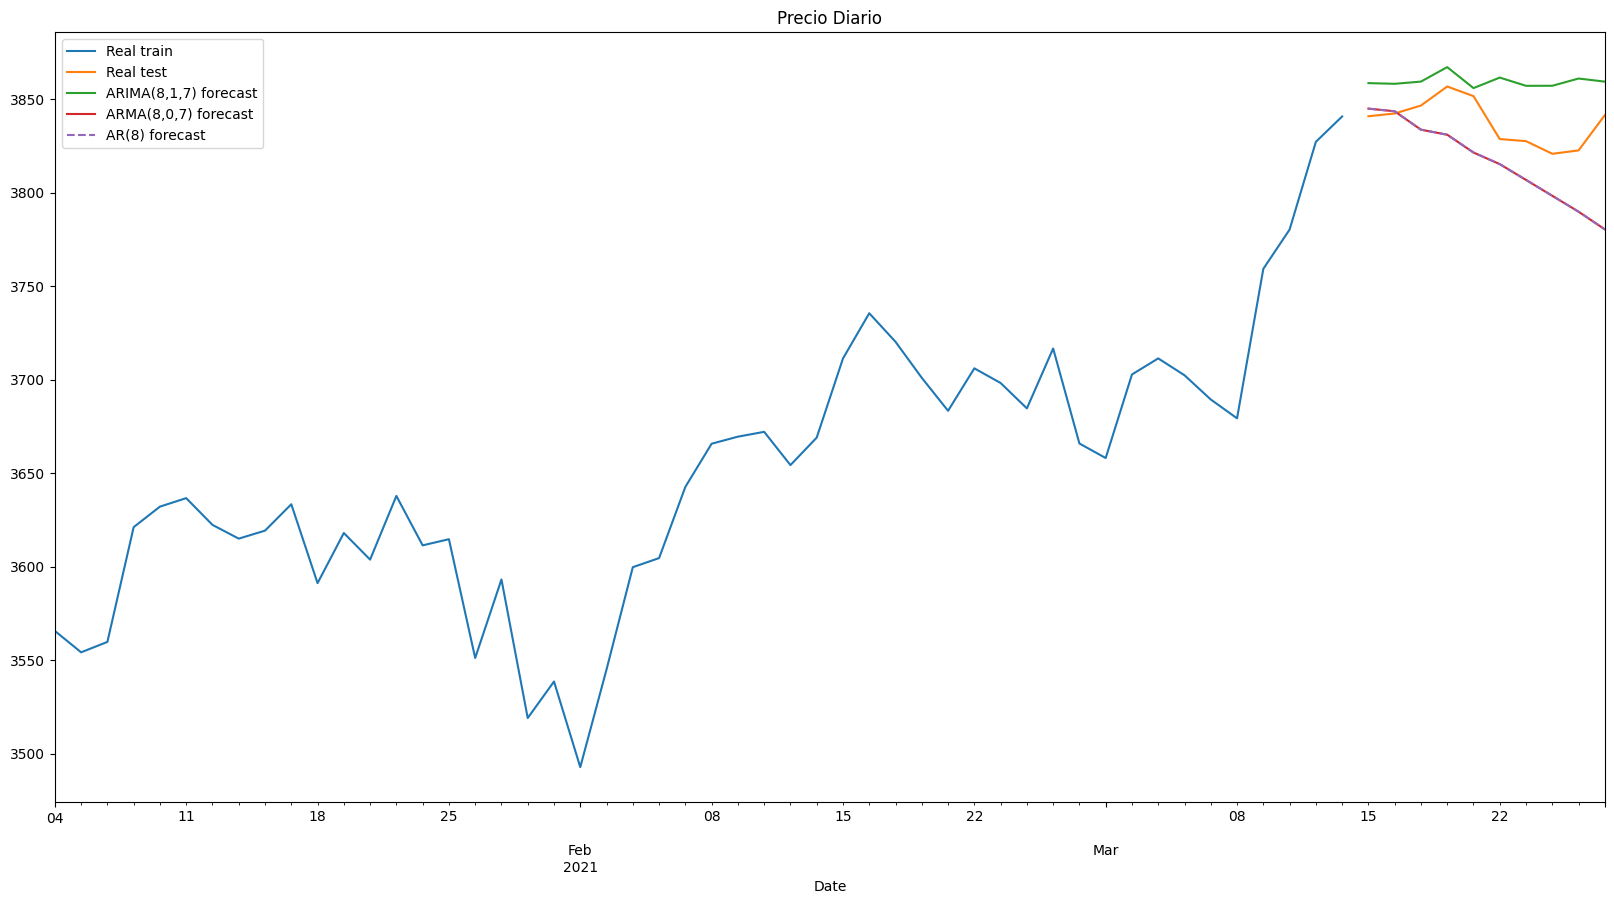

In [161]:
fig, ax = plt.subplots()
ax = wd_train.Open[800:].plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real train')
ax = wd_test.Open.plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real test')

# ARIMA(8,1,7)
model_arima = ARIMA(wd_train.Open, order=(8,1,7))
results_arima = model_arima.fit()
results_arimafore = results_arima.forecast(steps=10)
results_arimafore.index=wd_test.Open.index

# ARMA(8,7)
model_arma = ARIMA(wd_train.Open, order=(8,0,7))
results_arma = model_arma.fit()
results_arimafore = results_arima.forecast(steps=10)
results_arimafore.index=wd_test.Open.index

# AR(8)
model_ar = ARIMA(wd_train.Open, order=(8,0,0))
results_ar = model_ar.fit()
results_arfore = results_ar.forecast(steps=10)
results_arfore.index=wd_test.Returns.index

# Plot de los resultados
ax = results_arimafore.plot(ax=ax,label='ARIMA(8,1,7) forecast')
ax = results_arfore.plot(ax=ax, label='ARMA(8,0,7) forecast')
ax = results_arfore.plot(ax=ax, label='AR(8) forecast', linestyle='--')
plt.legend(loc="upper left")
plt.show()

- Una vez entrenado el modelo ARIMA(8,1,7), visualizamos un predict plot del modelo ARIMA(8,1,7) para ver si se ajusta bien a los valores reales de la serie y lo comparamos con los modelos ARMA(8,7) y AR(8) para ver cual funciona mejor.

Como podemos observar, el modelo ARIMA(8,1,7) se ajusta bastante mejor que ARMA(8,7) y AR(8) a los valores reales de la serie. Por tanto, podemos decir que el modelo ARIMA(8,1,7) es el mejor modelo que tenmos hasta ahora para predecir los valores de la serie.

### 3.2 SARIMA

- Para poder aplicar SARIMA a nuestra serie, primero tenemos que ver si la serie es estacionaria. Como ya hicimos al principio de este notebook, vemos que la serie no es estacionaria, pero su segunda integración sí lo es. 

Para sacar los hiparparámetros de SARIMA, usaremos el la herramienta ``pmdarima``: ``auto_arima``. Esta herramienta nos permite sacar los mejores hiperparámetros para el modelo SARIMA. Donde destacamos la eleccion de m=5 en auto sarima. Esto se debe a que el periodo en una "season" es 5, ya que para nuestro modelo, 1 semana son 7 dias pero de los cuales solo 5 son laborales en las cuales abre la bolsa. Aunque hay festivos adicionales a los fines de semana que hace que cierre la bolsa. Sin embargo, este caso solo ocurre 5 veces al año. Por lo cual mantenemos el valor 5.

In [162]:
# Auto ARIMA para encontrar el mejor modelo para SARIMA
# =====================================================================
auto_arima_model = auto_arima(wd_train.Open, start_p=1, start_q=1,
                              max_p=5, max_q=5, m=5,
                              start_P=0, seasonal=True,
                              d=None, D=1, trace=True,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[5] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(0,0,0)(0,1,0)[5] intercept   : AIC=10160.305, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[5] intercept   : AIC=8787.637, Time=0.58 sec
 ARIMA(0,0,1)(0,1,1)[5] intercept   : AIC=9518.199, Time=0.27 sec
 ARIMA(0,0,0)(0,1,0)[5]             : AIC=10158.390, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[5] intercept   : AIC=8985.374, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[5] intercept   : AIC=8703.214, Time=1.07 sec
 ARIMA(1,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(1,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(0,0,0)(2,1,0)[5] intercept   : AIC=10156.197, Time=0.81 sec
 ARIMA(2,0,0)(2,1,0)[5] intercept   : AIC=8678.869, Time=1.46 sec
 ARIMA(2,0,0)(1,1,0)[5] intercept   : AIC=8761.615, Time=0.50 sec
 ARIMA(2,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=2.12 sec
 ARIMA(2,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(3,0,0)(2,1,0)[5] intercept   : AIC=8649.865, Tim

Una vez realizado el autoarima, vemos que el mejor modelo es el SARIMA(3,0,1)(2,1,0)[5]. Por tanto, usaremos este modelo para predecir los valores de la serie.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.28835D+00    |proj g|=  5.09452D-01



At iterate    5    f=  5.10814D+00    |proj g|=  8.42928D-03

At iterate   10    f=  5.10229D+00    |proj g|=  2.25169D-02


 This problem is unconstrained.



At iterate   15    f=  5.08452D+00    |proj g|=  2.26918D-02

At iterate   20    f=  5.08011D+00    |proj g|=  1.01473D-02

At iterate   25    f=  5.07968D+00    |proj g|=  1.88436D-03

At iterate   30    f=  5.07806D+00    |proj g|=  1.86974D-02

At iterate   35    f=  5.07733D+00    |proj g|=  3.47478D-03

At iterate   40    f=  5.07726D+00    |proj g|=  1.47498D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     48      1     0     0   4.513D-06   5.077D+00
  F =   5.0772635911107900     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


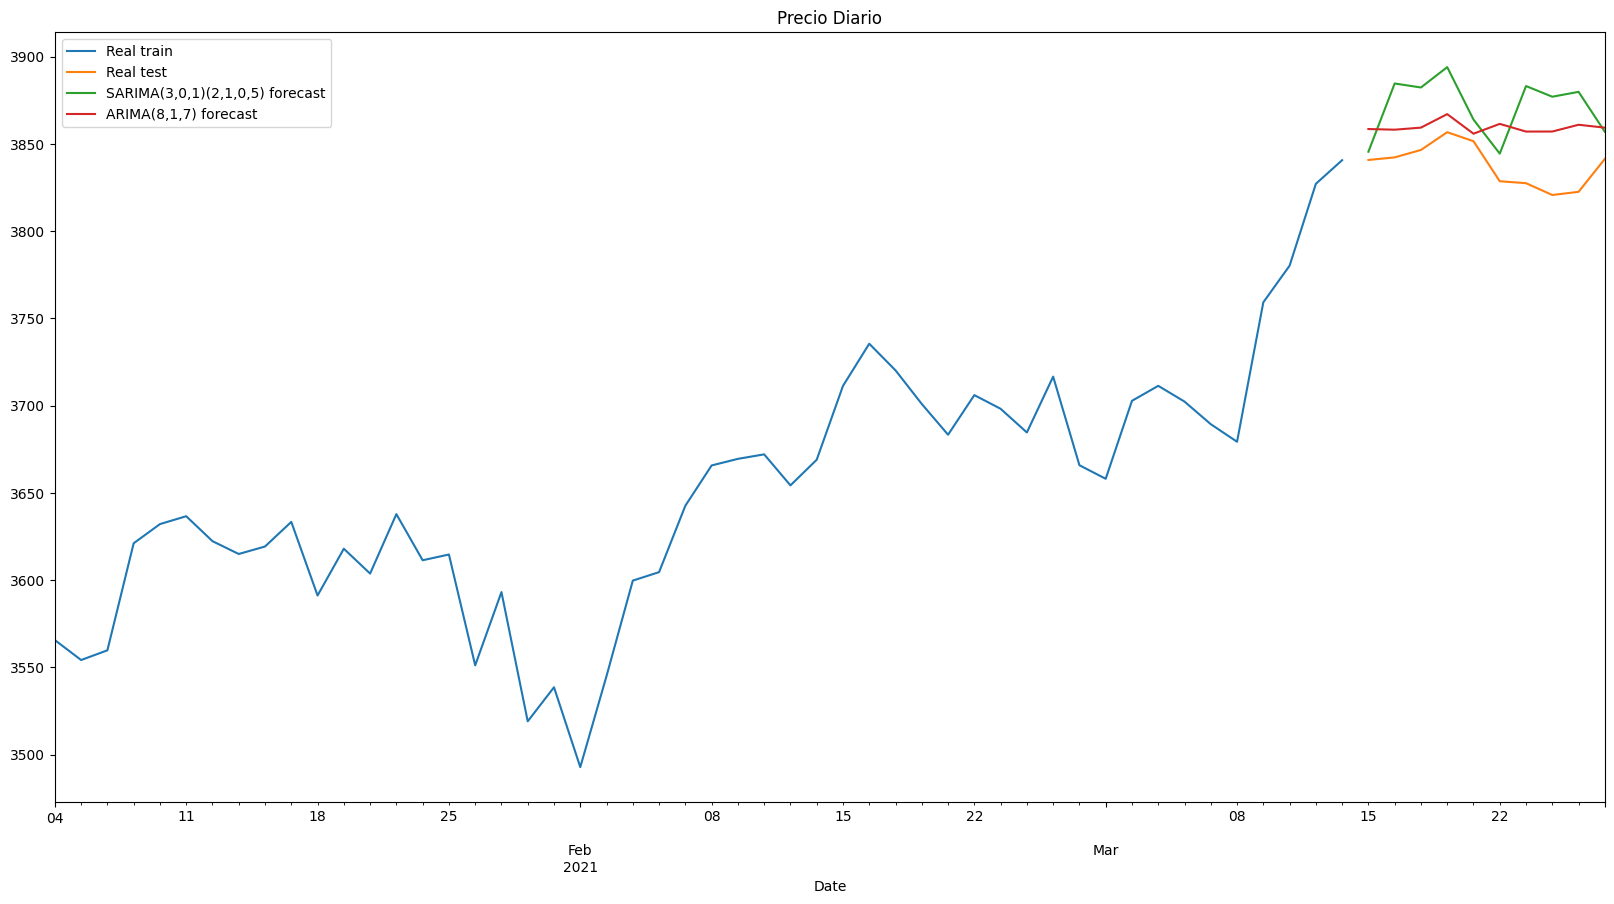

In [163]:
fig, ax = plt.subplots()
ax = wd_train.Open[800:].plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real train')
ax = wd_test.Open.plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real test')

model_sarima = SARIMAX(wd_train.Open, order=(3,0,1),seasonal_order=(2,1,0,5),enforce_invertibility=False)
results_sarima = model_sarima.fit()
results_sarimafore = results_sarima.forecast(steps=10)
results_sarimafore.index=wd_test.Open.index

ax = results_sarimafore.plot(ax=ax,label='SARIMA(3,0,1)(2,1,0,5) forecast')
ax = results_arimafore.plot(ax=ax,label='ARIMA(8,1,7) forecast')
plt.legend(loc="upper left")
plt.show()

- Pese al uso de la herramienta ``auto_arima``, podemos observar, que el modelo SARIMA(3,0,1)(2,1,0)[5] no se ajusta tan bien a los valores reales de la serie como el modelo ARIMA(8,1,7). Por tanto, podemos decir que el modelo ARIMA(8,1,7) es el mejor modelo que tenmos hasta ahora para predecir los valores de la serie.

### 3.3 SARIMAX

SARIMAX es un modelo de predicción que permite añadir variables exógenas al modelo SARIMA. Para ello, usaremos el dataset de noticias financieras francesas que hemos preprocesado anteriormente. A partir de este dataset, escogeremos la revista más influyente con respecto a los valores de la bolsa europea. Para ello, usaremos el análisis de sentimientos que cada noticia tiene. Una vez elegida dicha revista, la usaremos como variable exógena en el modelo SARIMAX.

In [164]:
# Cargamos el dataset de noticias en francés
# =====================================================================
working_news = news_french[['Date', 'Agency', 'Sentiment Vader TextURL']].copy() # seleccionamos las columnas que nos interesan (fecha, agencia y sentimiento) explicadas con anterioridad
working_news['Date'] = pd.to_datetime(working_news['Date'], format='%d.%m.%Y') # transformamos la columa de fecha a formato datetime

- Hacemos un profiling del dataset por si antes en la parte de preprocesado hemos pasado por alto cualquier información valiao para el modelo.

In [ ]:
profile = ProfileReport(working_news, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

- Para obtener la revista más influyente, primero eliminaremos las revistas con más noticias sin publicar, como es obvio. Para ello:

In [165]:
# Dividimos news french por agency 
# =====================================================================
news_agency = working_news.groupby('Agency')

# creamos un dataframe para cada agencia guardado en un diccionario
news_agency_dict = {}
for agency, news in news_agency:
    news_agency_dict[agency] = news

Ahora bien, el profiling de los datos muestra que existen bastantes revistas con noticias sin publicar en varios días. Por tanto, para mitigar los valores vacíos:

- A las noticias publicadas en festivos se ha unificado con el siguiente dia laboral. De forma que si la noticia es publicada un sábado, se uniría con el siguiente dia laboral, osea el lunes, haciendo de esta forma la media entre las noticias de sabado y lunes.

In [166]:
for agency, news in news_agency_dict.items():
    news['target_date'] = pd.NaT  # Initialize with Not-A-Time (NaT)

    news['target_date'] = news['Date'].map(
        lambda x: x if x in euro_open.index else euro_open[euro_open.index > x].index[0]
    )
    news.reset_index(inplace=True)
    # drop Date column
    news.drop(['Date'], axis=1, inplace=True)
    # rename target_date to Date and set it as index
    news.rename(columns={'target_date': 'Date'}, inplace=True)


In [167]:
# total date range
# =====================================================================
min_date = working_news.Date.min()
max_date = working_news.Date.max()

# Obtenemos el número de días total
num_days = (max_date - min_date).days

# Agrupar por agencia y contar las fechas únicas
dias_publicacion = working_news.groupby('Agency')['Date'].nunique()

# dias_publicacion ahora contiene el número de días diferentes de publicación para cada agencia
print(dias_publicacion)

Agency
AFP                                       29
AFP Video                                 28
BFG Capital                                1
Banque Richelieu France                    1
Biotech Finances                           3
Boursorama                               151
Boursorama Banque                          7
Boursorama CP                             58
Boursorama avec Media Services            20
Boursorama avec Newsgene                   7
Boursorama avec Pratique.fr                4
Café de la Bourse                          2
DT Expert                                  1
Ecorama                                  748
Edit-Place                                22
Edmond de Rothschild AM                    3
EuroLand Corporate                         1
France 24                                920
Genesta                                    1
GreenSome Finance                          1
H24 Finance pour Boursorama                9
IDIX                                     258
Le 

- Una vez ya tenemos las noticias unificadas, procedemos a elegir como pliculas candidatas, las revistas que hayan publicado por lo menos la mitad de los días del dataset. Esto es debido a que si una revista no publica la mitad de los días, no se puede considerar como una revista influyente, como explicamos con anterioridad.

In [168]:
# Solo tomaremos como candidatas a las agencias que hayan publicado al menos el 50% de los días
# =====================================================================
agencies = dias_publicacion[dias_publicacion > (num_days * 0.5)].index

# Para cada agencia candidata, agrupamos por fecha y obtenemos la media de la columna Sentiment Vader TextURL
news_agency_mean_dict = {}
for agency, news in news_agency_dict.items():
    news_agency_mean_dict[agency] = news[['Date', 'Sentiment Vader TextURL']].groupby('Date').mean()

news_agency_mean_dict = {agency: news_agency_mean_dict[agency] for agency in agencies}

- Una vez tenemos las revistas candidatas, procedemos a elegir la revista más influyente. Para ello, usaremos el análisis de sentimientos que cada noticia tiene. Para ello, calcularemos la media de los sentimientos de cada revista y aplicaremos  el modelo sarimax con cada revista para ver cual es la que mejor se ajusta a los valores reales de la serie.

    Por tanto, la revista que mejor se ajusta a los valores reales de la serie es la revista  será la más influyente. Por tanto, usaremos esta revista como variable exógena en el modelo SARIMAX.

In [169]:
# Add the mean of the each sentiments column to the euro_open dataframe, if the date is not in the news_agency_mean_dict, then the value is 0
# =====================================================================
for agency, news in news_agency_mean_dict.items():
    euro_open[agency] = euro_open.index.map(lambda x: news.loc[x, 'Sentiment Vader TextURL'] if x in news.index else 0)

- Aplicamos SARIMAX a cada revista candidata

In [170]:
# train test split
# =====================================================================
size = len(euro_open) - 10
wd_train, wd_test = euro_open.iloc[:size], euro_open.iloc[size:]

In [171]:
# for each agency we do the sarimax model
# =====================================================================
sarimax_results_dict = {}
for agency, news in news_agency_mean_dict.items():
    model_sarimax = SARIMAX(wd_train.Open,exog=wd_train[agency],order=(3,0,1),seasonal_order=(2,1,0,5),enforce_invertibility=False)
    sarimax_results_dict[agency] = model_sarimax.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.32588D+00    |proj g|=  5.14274D-01


 This problem is unconstrained.



At iterate    5    f=  5.14403D+00    |proj g|=  7.88597D-03

At iterate   10    f=  5.13906D+00    |proj g|=  1.50435D-02

At iterate   15    f=  5.10976D+00    |proj g|=  1.74906D-02

At iterate   20    f=  5.10075D+00    |proj g|=  1.72555D-02

At iterate   25    f=  5.09985D+00    |proj g|=  6.51449D-03

At iterate   30    f=  5.09221D+00    |proj g|=  3.21032D-02

At iterate   35    f=  5.08870D+00    |proj g|=  2.21720D-02

At iterate   40    f=  5.08710D+00    |proj g|=  1.21729D-02

At iterate   45    f=  5.08619D+00    |proj g|=  1.52688D-02

At iterate   50    f=  5.07669D+00    |proj g|=  1.57443D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.11180D+00    |proj g|=  8.72532D-03

At iterate   10    f=  5.10672D+00    |proj g|=  2.37291D-02

At iterate   15    f=  5.08660D+00    |proj g|=  2.15390D-02

At iterate   20    f=  5.08175D+00    |proj g|=  3.91649D-03

At iterate   25    f=  5.08145D+00    |proj g|=  3.39053D-03

At iterate   30    f=  5.08034D+00    |proj g|=  2.51545D-02

At iterate   35    f=  5.07942D+00    |proj g|=  2.95681D-03

At iterate   40    f=  5.07933D+00    |proj g|=  7.10863D-04

At iterate   45    f=  5.07921D+00    |proj g|=  5.78542D-03

At iterate   50    f=  5.07777D+00    |proj g|=  1.21056D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.12163D+00    |proj g|=  8.90018D-03

At iterate   10    f=  5.11662D+00    |proj g|=  2.47419D-02

At iterate   15    f=  5.09308D+00    |proj g|=  2.38790D-02

At iterate   20    f=  5.08690D+00    |proj g|=  2.52192D-03

At iterate   25    f=  5.08662D+00    |proj g|=  1.10550D-02

At iterate   30    f=  5.08217D+00    |proj g|=  2.92091D-02

At iterate   35    f=  5.08041D+00    |proj g|=  8.42133D-03

At iterate   40    f=  5.08014D+00    |proj g|=  8.59780D-03

At iterate   45    f=  5.07741D+00    |proj g|=  2.88993D-02

At iterate   50    f=  5.07668D+00    |proj g|=  3.78469D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.10746D+00    |proj g|=  8.05723D-03

At iterate   10    f=  5.10121D+00    |proj g|=  2.25499D-02

At iterate   15    f=  5.08369D+00    |proj g|=  1.68187D-02

At iterate   20    f=  5.07981D+00    |proj g|=  2.96153D-03

At iterate   25    f=  5.07947D+00    |proj g|=  1.12908D-02

At iterate   30    f=  5.07738D+00    |proj g|=  1.25065D-02

At iterate   35    f=  5.07693D+00    |proj g|=  4.44573D-04

At iterate   40    f=  5.07692D+00    |proj g|=  9.63887D-04

At iterate   45    f=  5.07672D+00    |proj g|=  9.03205D-03

At iterate   50    f=  5.07654D+00    |proj g|=  4.49405D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

- Elegimos la mejor revista a través del AIC (Akaike Information Criterion)

In [172]:
# get the best agency
# =====================================================================
best_agency = None
best_aic = None
for agency, results in sarimax_results_dict.items():
    if best_aic is None:
        best_agency = agency
        best_aic = results.aic
    elif results.aic < best_aic:
        best_agency = agency
        best_aic = results.aic

# print the best agency
best_agency

'Reuters'

#### SARIMAX con la revista más influyente

- Una vez elegida la revista más influyente **Reuters**, aplicamos SARIMAX a dicha revista.



Primero vemos si la serie con la revista más influyente es estacionaria. Como podemos observar, la serie es estacionaria pues el p-valor es menor que 0.05 y el estadístico de prueba es menor que los valores críticos en los diferentes niveles de significación. Por tanto, podemos usar el modelo SARIMAX para predecir los valores de la serie.

In [173]:
sts.adfuller(euro_open[best_agency])

(-8.902801298958481,
 1.1590984985073733e-14,
 6,
 853,
 {'1%': -3.438039434877692,
  '5%': -2.8649342774762423,
  '10%': -2.5685773775887872},
 139.29339963035545)

Para la elección de hiperparámteros, volveremos a usar la herramienta ``auto_arima``. Como podemos observar, el mejor modelo es el SARIMAX(1,0,0)(2,1,0)[5] . Por tanto, usaremos este modelo para predecir los valores de la serie.

In [174]:
auto_arima_model = auto_arima(wd_train[best_agency], start_p=1, start_q=1,
                              max_p=5, max_q=5, m=5,
                              start_P=0, seasonal=True,
                              d=None, D=1, trace=True,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=True)

Performing stepwise search to minimize aic


 ARIMA(1,0,1)(0,1,1)[5] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(0,0,0)(0,1,0)[5] intercept   : AIC=707.527, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[5] intercept   : AIC=499.352, Time=0.26 sec
 ARIMA(0,0,1)(0,1,1)[5] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(0,0,0)(0,1,0)[5]             : AIC=705.534, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[5] intercept   : AIC=704.986, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[5] intercept   : AIC=412.966, Time=0.69 sec
 ARIMA(1,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=1.70 sec
 ARIMA(1,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(0,0,0)(2,1,0)[5] intercept   : AIC=414.886, Time=0.60 sec
 ARIMA(2,0,0)(2,1,0)[5] intercept   : AIC=413.936, Time=0.80 sec
 ARIMA(1,0,1)(2,1,0)[5] intercept   : AIC=414.579, Time=0.86 sec
 ARIMA(0,0,1)(2,1,0)[5] intercept   : AIC=413.257, Time=0.38 sec
 ARIMA(2,0,1)(2,1,0)[5] intercept   : AIC=414.674, Time=2.12 sec
 ARIMA(1,0,0)(2,1,0)[5]             : AIC=410.995, Time=0.33 sec
 ARIMA(1,0,0)(1,1,0)[5]             : AIC

- Hagamos la comparación visual de los modelos SARIMA y SARIMAX para ver cual se ajusta mejor a los valores reales de la serie. Para ello, antes predecimos los valores exógenos de la serie con el modelo SARIMAX:

In [175]:
# predict the next 10 days
# =====================================================================
exog_test = SARIMAX(wd_train[best_agency], order=(1,0,0),seasonal_order=(2,1,0,5), enforce_invertibility=False)
exog_results = exog_test.fit()
exog_forecast = exog_results.forecast(steps=10)
exog_forecast.index=wd_test.Open.index

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.63505D-01    |proj g|=  7.95406D-01

At iterate    5    f=  2.37078D-01    |proj g|=  5.81022D-03



At iterate   10    f=  2.37056D-01    |proj g|=  1.27120D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   3.159D-05   2.371D-01
  F =  0.23705608664875527     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


In [176]:
exog_forecast

Date
2021-03-15    0.105639
2021-03-16    0.093565
2021-03-17   -0.001903
2021-03-18    0.141508
2021-03-19    0.204241
2021-03-22    0.145191
2021-03-23    0.048065
2021-03-24   -0.030257
2021-03-25    0.119267
2021-03-26    0.183999
Name: predicted_mean, dtype: float64

Una vez predichos, pasamos a visualizar los valores predichos por ambos modelos.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.28835D+00    |proj g|=  5.09452D-01

At iterate    5    f=  5.10814D+00    |proj g|=  8.42928D-03

At iterate   10    f=  5.10229D+00    |proj g|=  2.25169D-02


 This problem is unconstrained.



At iterate   15    f=  5.08452D+00    |proj g|=  2.26918D-02

At iterate   20    f=  5.08011D+00    |proj g|=  1.01473D-02

At iterate   25    f=  5.07968D+00    |proj g|=  1.88436D-03

At iterate   30    f=  5.07806D+00    |proj g|=  1.86974D-02

At iterate   35    f=  5.07733D+00    |proj g|=  3.47478D-03

At iterate   40    f=  5.07726D+00    |proj g|=  1.47498D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     48      1     0     0   4.513D-06   5.077D+00
  F =   5.0772635911107900     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  5.10746D+00    |proj g|=  8.05723D-03

At iterate   10    f=  5.10121D+00    |proj g|=  2.25499D-02

At iterate   15    f=  5.08369D+00    |proj g|=  1.68187D-02

At iterate   20    f=  5.07981D+00    |proj g|=  2.96153D-03

At iterate   25    f=  5.07947D+00    |proj g|=  1.12908D-02

At iterate   30    f=  5.07738D+00    |proj g|=  1.25065D-02

At iterate   35    f=  5.07693D+00    |proj g|=  4.44573D-04

At iterate   40    f=  5.07692D+00    |proj g|=  9.63887D-04

At iterate   45    f=  5.07672D+00    |proj g|=  9.03205D-03

At iterate   50    f=  5.07654D+00    |proj g|=  4.49405D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

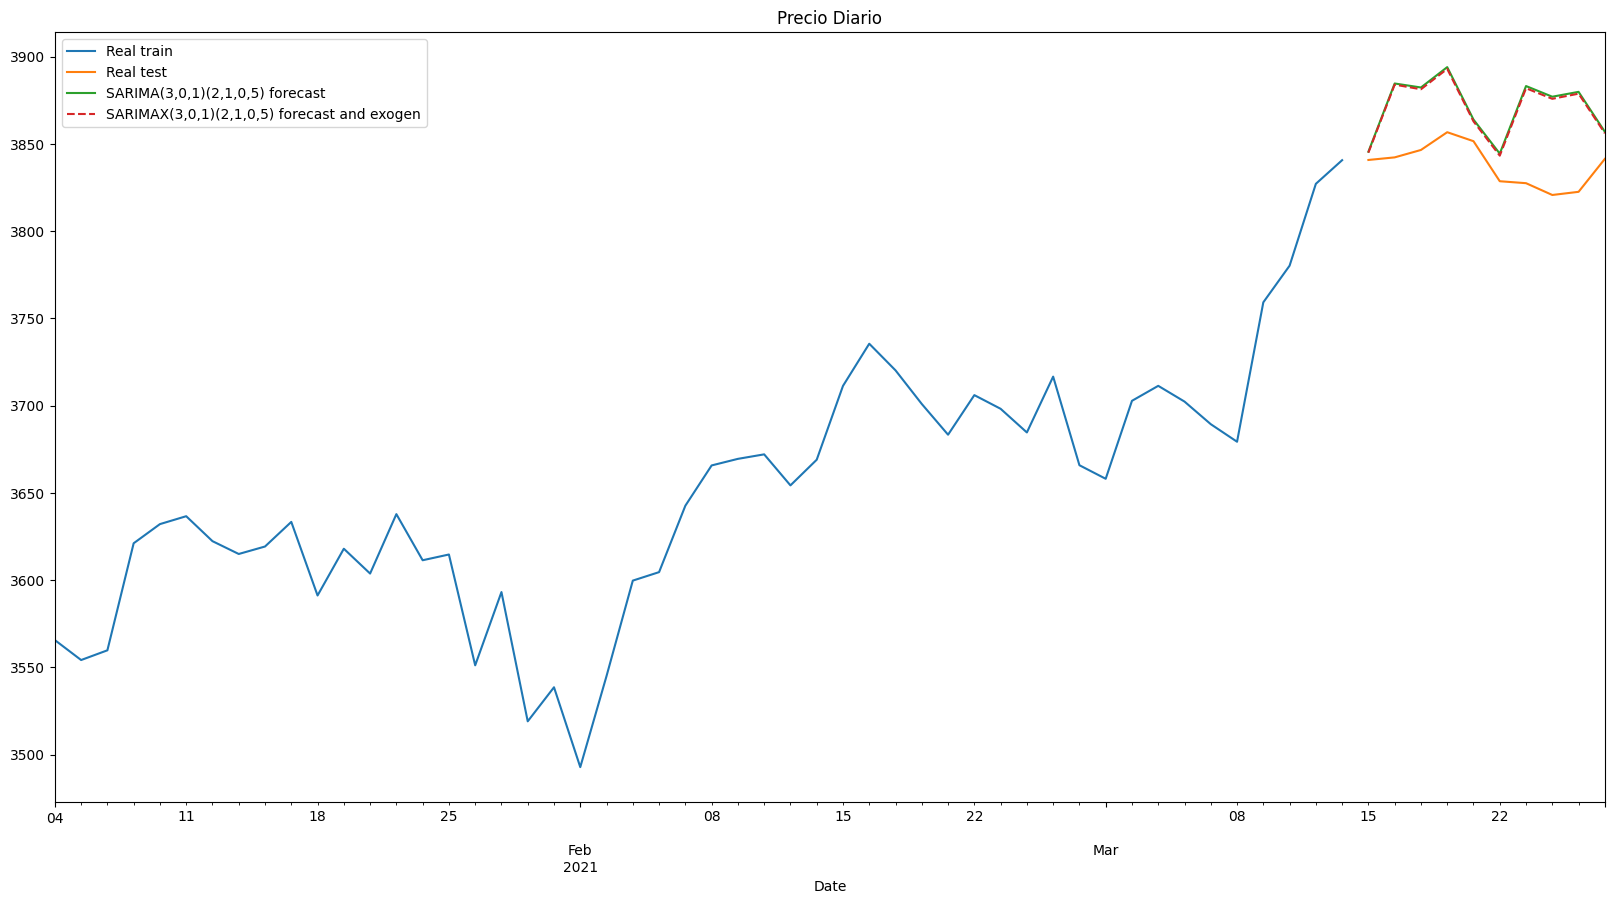

In [177]:
fig, ax = plt.subplots()
ax = wd_train.Open[800:].plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real train')
ax = wd_test.Open.plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real test')

model_sarima = SARIMAX(wd_train.Open, order=(3,0,1),seasonal_order=(2,1,0,5), enforce_invertibility=False)
results_sarima = model_sarima.fit()
results_sarimafore = results_sarima.forecast(steps=10)
results_sarimafore.index=wd_test.Open.index

model_sarimax = SARIMAX(wd_train.Open, exog=wd_train[best_agency], order=(3,0,1),seasonal_order=(2,1,0,5), enforce_invertibility=False)
sarimax_results = model_sarimax.fit()
results_sarimaxfore = sarimax_results.forecast(steps=10, exog=exog_forecast)
results_sarimaxfore.index=wd_test.Open.index


ax = results_sarimafore.plot(ax=ax, label='SARIMA(3,0,1)(2,1,0,5) forecast', linestyle='-')
ax = results_sarimaxfore.plot(ax=ax, label='SARIMAX(3,0,1)(2,1,0,5) forecast and exogen', linestyle='--')
plt.legend(loc="upper left")
plt.show()

- Conclusiones:

Tras añadir la variable exógena, vemos que los resultados son prácticamente parecidos con respecto al SARIMAX(3,0,1)(2,1,0)[5] sin variable exógena. Esto puede deberse a que la variable exógena elegida no influye en la serie o que el modelo SARIMAX(3,0,1)(2,1,0)[5] ya es un buen modelo para predecir los valores de la serie dentro de las limitaciones de la predicción de valores de una serie temporal de caracter pseudo-aleatorio, pues consigue dar una predicción aceptable de los valores de la serie.

Tal vez algunas noticias que no sean muy influyentes en la bolsa que esten haciendo que el modelo no se ajuste bien a los valores reales de la serie. Por tanto, para mejorar el modelo SARIMAX, se podría hacer un análisis de tópicos de las noticias para ver cuales son los tópicos que más influyen en la bolsa y así poder elegir las noticias más influyentes para la bolsa.

## 4. Análisis de tópicos de la revista más relevante

En este apartado, se realizará el analisis de tópicos de la revista más relevante: **Reuters**. Todo ello, con el objetivo de intentar encontrar los tópicos que más influyen a que una noticia tenga un sentimiento positivo o negativo sobre la bolsa, de modo que podamos conseguir una predicción más precisa de los valores de la bolsa.

Por ello, hemos decidido aprovechar la potencia los **Modelos Probabilísticos de Tópicos** para poder conseguir este objetivo. En este caso hemos usado el **modelo LDA** visto en la asignatura para hacer un análisis de topicos sobre la columna que contiene el resumen de las noticias en inglés.

La idea princiapl, es conseguir separar las noticias de Reuters en tópicos diferentes. Entonces, lo que buscamos es encontrar el tópico de la agencia que tenga más impacto sobre nuestra predicción. De modo que, los sentimientos de los otros tópicos que no sean relevantes no se tengan en cuenta, eliminando de esta manera el ruido que puedan aportar.

El porqué decidimos hacer este análisis de tópicos sobre la revista Reuters es porque la predicción realizada con dicho revista como exógena, es la misma que la predicción realizada sin ninguna variable exógena. Por tanto, queremos ver si podemos encontrar los tópicos que más influyen a que una noticia tenga un sentimiento positivo o negativo sobre la bolsa, de modo que podamos conseguir una predicción más precisa de los valores de la bolsa.

In [71]:
# Elegimos a la revista Reuters
# =====================================================================
reuters = news_french[news_french['Agency'] == 'Reuters']

reuters.reset_index(inplace=True)
reuters.drop(['index'], axis=1, inplace=True) # quitamos el antiguo index

display(reuters.head())

,Numero news,Numero page,Numero,Date,Heure,Titre,Contenu,Agency,URL,textURL,Nbr image,seconds to 2010,days to 2010,dateDT,Title eng,Content eng,textURL eng,Sentiment Vader Title,Sentiment Vader Text,Sentiment Vader TextURL
0,3,2127,16,19.10.2017,10:59,"En Grande-Bretagne, les ventes au détail subis...",LONDRES (Reuters) - Les ventes au détail en Gr...,Reuters,https://www.boursorama.com/actualite-economiqu...,LONDRES (Reuters) - Les ventes au détail en Gr...,1,246106740.0,2848.457639,2017-10-19 10:59:00,"In Great Britain, retail sales stopped in Sept...",LONDON (Reuters) - Retail sales in Great Brita...,LONDON (Reuters) - Retail sales in Great Brita...,0.4939,0.3182,-0.4019
1,5,2127,14,19.10.2017,11:58,"Dmitri Rybolovlev, président de l'AS Monaco, i...","NICE (Reuters) - Le président de l'AS Monaco, ...",Reuters,https://www.boursorama.com/actualite-economiqu...,"NICE (Reuters) - Le président de l'AS Monaco, ...",1,246110280.0,2848.498611,2017-10-19 11:58:00,"Dmitri Rybolovlev, President of AS Monaco, cha...","NICE (Reuters) - The president of AS Monaco, D...","NICE (Reuters) - The president of AS Monaco, D...",-0.2023,-0.3954,0.9386
2,6,2127,13,19.10.2017,12:25,Amendes et gardes à vue pour les harceleurs de...,PARIS (Reuters) - Les agents de la police de s...,Reuters,https://www.boursorama.com/actualite-economiqu...,PARIS (Reuters) - Les agents de la police de s...,1,246111900.0,2848.517361,2017-10-19 12:25:00,"Fines and custody for street harassers, says C...",PARIS (Reuters) - The daily security police of...,PARIS (Reuters) - The officers of the daily se...,-0.5859,0.4767,0.5719
3,8,2127,11,19.10.2017,14:34,Les eurodéputés proposent d'interdire le glyph...,PARIS (Reuters) - Les députés européens de la ...,Reuters,https://www.boursorama.com/actualite-economiqu...,PARIS (Reuters) - Les députés européens de la ...,1,246119640.0,2848.606944,2017-10-19 14:34:00,MEPs propose banning glyphosate by 2020,PARIS (Reuters) - MEPs in the Committee on the...,PARIS (Reuters) - MEPs in the Committee on the...,0.0000,-0.7841,-0.7264
4,13,2127,6,19.10.2017,19:10,"Hausse de 4,7% des tarifs du courrier en 2018",PARIS (Reuters) - Les tarifs du courrier augme...,Reuters,https://www.boursorama.com/actualite-economiqu...,PARIS (Reuters) - Les tarifs du courrier augme...,1,246136200.0,2848.798611,2017-10-19 19:10:00,4.7% increase in mail rates in 2018,PARIS (Reuters) - Mail rates will increase by ...,The price of the mail will increase by 4.7% on...,0.3182,0.5267,0.8151


In [118]:
# lista de documentos
documents = reuters['Content eng'].tolist()

# bag-of-words
tf_vectorizer = CountVectorizer(
    stop_words='english',
    min_df=2, # minimo número de documentos que tiene que aparecer una palabra
    max_df=0.25, # maximo número de documentos que tiene que aparecer una palabra
    lowercase=True,
    max_features=50000,
    token_pattern='[a-zA-Z0-9]{3,}',  
    analyzer = 'word'
)
bag_of_words = tf_vectorizer.fit_transform(documents)
dictionary = tf_vectorizer.get_feature_names_out()
vocabulary = tf_vectorizer.vocabulary_

print("Vocabulary Size: ", len(dictionary))

Vocabulary Size:  14641


Lista ordenada por frecuencia:

In [119]:
s = bag_of_words.toarray().sum(axis=0)
st = sorted(range(len(s)), key=lambda k: s[k], reverse=True)
for i,x in enumerate(st[:20]):
  print(dictionary[x],s[x])

said 3654
france 3326
announced 3036
european 2813
coronavirus 2764
french 2722
new 2564
thursday 2462
wednesday 2443
tuesday 2430
minister 2409
friday 2110
monday 2109
president 1992
government 1972
year 1825
according 1702
health 1582
state 1477
published 1385


In [120]:
# valores de alpha y beta para el modelo LDA
topics = 5
alpha = 0.1
beta = 0.05

# Ejecutamos el modelo LDA
lda = LatentDirichletAllocation(
    n_components=topics,
    doc_topic_prior=alpha,
    topic_word_prior=beta,
    max_iter=200,
    learning_method='online',
    evaluate_every=1,
    n_jobs = -1,
    random_state=0,
    verbose=1)
lda.fit(bag_of_words)


iteration: 1 of max_iter: 200, perplexity: 4107.4648
iteration: 2 of max_iter: 200, perplexity: 3574.8113
iteration: 3 of max_iter: 200, perplexity: 3469.0798
iteration: 4 of max_iter: 200, perplexity: 3426.5421
iteration: 5 of max_iter: 200, perplexity: 3404.0657
iteration: 6 of max_iter: 200, perplexity: 3390.4158
iteration: 7 of max_iter: 200, perplexity: 3381.5181
iteration: 8 of max_iter: 200, perplexity: 3375.3207
iteration: 9 of max_iter: 200, perplexity: 3370.6625
iteration: 10 of max_iter: 200, perplexity: 3367.0710
iteration: 11 of max_iter: 200, perplexity: 3364.1691
iteration: 12 of max_iter: 200, perplexity: 3361.8166
iteration: 13 of max_iter: 200, perplexity: 3359.8528
iteration: 14 of max_iter: 200, perplexity: 3358.2101
iteration: 15 of max_iter: 200, perplexity: 3356.8352
iteration: 16 of max_iter: 200, perplexity: 3355.7122
iteration: 17 of max_iter: 200, perplexity: 3354.7103
iteration: 18 of max_iter: 200, perplexity: 3353.8604
iteration: 19 of max_iter: 200, perpl

LatentDirichletAllocation(doc_topic_prior=0.1, evaluate_every=1,
                          learning_method='online', max_iter=200,
                          n_components=5, n_jobs=-1, random_state=0,
                          topic_word_prior=0.05, verbose=1)

In [126]:
no_top_words = 10
no_top_documents = 2

doc_topics = lda.transform(bag_of_words)
topics = lda.components_

print("LDA Topics")
for topic_idx, topic in enumerate(topics):
    print("-"*30)
    print(" Topic ",(topic_idx)," :")
    print("["," | ".join([dictionary[i]
                    for i in topic.argsort()[:-no_top_words - 1:-1]]),"]")
    top_doc_indices = np.argsort( doc_topics[:,topic_idx] )[::-1][0:no_top_documents]
    for doc_index in top_doc_indices:
        row_index = doc_index +1
        print("[",doc_index,"] (",reuters.iloc[row_index]['Title eng'],") \'",reuters.iloc[row_index]['Content eng'],"\'", [ "{0:.5f}".format(weight) for weight in doc_topics[doc_index]])


LDA Topics
------------------------------
 Topic  0  :
[ minister | president | french | european | emmanuel | macron | said | government | state | france ]
[ 12 ] ( Halliburton exceeds expectations with North America ) ' (Reuters) - In the third quarter, Halliburton posted a profit above expectations, the oil services group having benefited from the increase in North American activity, its main market. The number of drilling wells in the United States, an indicator of future production, now exceeds 700 when it fell in 450 a year ago, the rise in oil prices prompting companies to reinvest ' ['0.99080', '0.00230', '0.00230', '0.00230', '0.00230']
[ 97 ] ( Kevin Spacey erased from a film that was finished ) ' LOS ANGELES (Reuters) - The director and producers of a film whose filming is complete and which is to be released on the screens on December 22 have removed Kevin Spacey from the credits and decided to shoot again all the scenes in which the actor appeared. This completely unusual 

#### 4.2 Evalualción de Tópicos

En este punto, una vez obtenidos los tópicos, vamos a evaluarlos para ver si son buenos o no. Para ello, usaremos la métrica **Perplexity** y el **log-likelihood**. Recuerda que un modelo con una mayor  log-likelihoody una menor perplejidad (exp (-1. * probabilidad logarítmica por palabra)) se considera bueno.

In [128]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(bag_of_words))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(bag_of_words))

# See model parameters
print(lda)

Log Likelihood:  -3531562.78424244
Perplexity:  3344.5381578041565
LatentDirichletAllocation(doc_topic_prior=0.1, evaluate_every=1,
                          learning_method='online', max_iter=200,
                          n_components=5, n_jobs=-1, random_state=0,
                          topic_word_prior=0.05, verbose=1)


Vamos a utilizar el Grid Search:

In [129]:
# Define Search Param
search_params = {'n_components': [3, 5, 10], 'doc_topic_prior': [.1, .3, .5], 'topic_word_prior': [.01, .03, .05]}

# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=0)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(bag_of_words)

GridSearchCV(estimator=LatentDirichletAllocation(learning_method='online',
                                                 learning_offset=50.0,
                                                 max_iter=5, random_state=0),
             param_grid={'doc_topic_prior': [0.1, 0.3, 0.5],
                         'n_components': [3, 5, 10],
                         'topic_word_prior': [0.01, 0.03, 0.05]})

Veamos la mejor configuración:

In [130]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(bag_of_words))

Best Model's Params:  {'doc_topic_prior': 0.5, 'n_components': 3, 'topic_word_prior': 0.05}
Best Log Likelihood Score:  -772893.0923986874
Model Perplexity:  2974.7442967999636


In [131]:
# valores de alpha y beta para el modelo LDA
topics = 3
alpha = 0.5
beta = 0.05 #las palabras respecto a topic

# Ejecutamos el modelo LDA
lda = LatentDirichletAllocation(
    n_components=topics,
    doc_topic_prior=alpha,
    topic_word_prior=beta,
    max_iter=200,
    learning_method='online',
    evaluate_every=1,
    n_jobs = -1,
    random_state=0,
    verbose=1)
lda.fit(bag_of_words)
#si perprejidad que no estabiliza, entonces tenemso que dar más iteraciones

iteration: 1 of max_iter: 200, perplexity: 3575.0112
iteration: 2 of max_iter: 200, perplexity: 3168.3681
iteration: 3 of max_iter: 200, perplexity: 3086.0080
iteration: 4 of max_iter: 200, perplexity: 3052.3373
iteration: 5 of max_iter: 200, perplexity: 3034.4740
iteration: 6 of max_iter: 200, perplexity: 3023.5433
iteration: 7 of max_iter: 200, perplexity: 3016.2788
iteration: 8 of max_iter: 200, perplexity: 3011.1385
iteration: 9 of max_iter: 200, perplexity: 3007.3275
iteration: 10 of max_iter: 200, perplexity: 3004.3966
iteration: 11 of max_iter: 200, perplexity: 3002.0697
iteration: 12 of max_iter: 200, perplexity: 3000.1744
iteration: 13 of max_iter: 200, perplexity: 2998.5995
iteration: 14 of max_iter: 200, perplexity: 2997.2741
iteration: 15 of max_iter: 200, perplexity: 2996.1486
iteration: 16 of max_iter: 200, perplexity: 2995.1831
iteration: 17 of max_iter: 200, perplexity: 2994.3470
iteration: 18 of max_iter: 200, perplexity: 2993.6179
iteration: 19 of max_iter: 200, perpl

LatentDirichletAllocation(doc_topic_prior=0.5, evaluate_every=1,
                          learning_method='online', max_iter=200,
                          n_components=3, n_jobs=-1, random_state=0,
                          topic_word_prior=0.05, verbose=1)

In [132]:
no_top_words = 10
no_top_documents = 2

doc_topics = lda.transform(bag_of_words)
topics = lda.components_

print("LDA Topics")
for topic_idx, topic in enumerate(topics):
    print("-"*30)
    print(" Topic ",(topic_idx)," :")
    print("["," | ".join([dictionary[i]
                    for i in topic.argsort()[:-no_top_words - 1:-1]]),"]")
    top_doc_indices = np.argsort( doc_topics[:,topic_idx] )[::-1][0:no_top_documents]
    for doc_index in top_doc_indices:
        row_index = doc_index +1
        print("[",doc_index,"] (",reuters.iloc[row_index]['Title eng'],") \'",reuters.iloc[row_index]['Content eng'],"\'", [ "{0:.5f}".format(weight) for weight in doc_topics[doc_index]])


LDA Topics
------------------------------
 Topic  0  :
[ minister | said | european | president | french | government | france | emmanuel | macron | state ]
[ 3324 ] ( Europeans: A victory of the RN would be serious for the economy, according to Le Maire ) ' PARIS (Reuters) - A victory of the National Rally (RN, ex-Front national) in the European elections would be detrimental to the French economy and to the single currency, said Bruno Le Maire on Sunday, a week before the election. If nationalisms, through Marine Le Pen, win on 26 May, it will be serious for the situation of our finances, ( ' ['0.97959', '0.01004', '0.01036']
[ 1204 ] ( Stéphane Bern sounds the alarm on the heritage ) ' PARIS (Reuters) - Stéphane Bern, entrusted by the Elysée with a mission on the preservation of the heritage, launched on Saturday a call for a national momentum and warned that he did not exclude leaving this mission at the end of the year if he had the feeling of being just a cache-misere. I arrived 

Hemos identificado tres tópicos principales en nuestro análisis:

- **Tópico 0 - Europa y Francia:** Este tópico abarca noticias principalmente centradas en Europa, con un enfoque particular en Francia. Parece que los eventos o situaciones específicas de Francia son predominantes en este conjunto de noticias.

- **Tópico 1 - Economía, Bancos y el Impacto del Coronavirus:** Noticias que se centran en temas económicos y bancarios. Es notable que la mayoría de estas noticias incluyen referencias al Coronavirus, destacando cómo la pandemia ha afectado significativamente a la economía mundial.

- **Tópico 2 - Coronavirus y Salud:** Este tópico se concentra en noticias relacionadas directamente con el Coronavirus y su impacto en la salud pública. Refleja la importancia y prevalencia del tema en el contexto actual.

Una vez identificados los tópicos más influyentes de la revista, los añadimos al dataset para volver a intentar predecir los valores de la bolsa europea con el modelo SARIMAX con los tópicos más importantes de la revista más influyente.

In [138]:
# añadimos los topicos al dataframe
# =====================================================================
topicnames = ["topic"+ str(x) for x in range(0, lda.n_components)]
norm_doc_topics = []
for i in doc_topics:
  norm_doc_topics.append([ "{0:.3f}".format(weight) for weight in i])
  
reuters['Topic'] = np.argmax(doc_topics, axis=1)
reuters['Topic'] = reuters['Topic'].map(lambda x: topicnames[x])

reuters

,Numero news,Numero page,Numero,Date,Heure,Titre,Contenu,Agency,URL,textURL,...,seconds to 2010,days to 2010,dateDT,Title eng,Content eng,textURL eng,Sentiment Vader Title,Sentiment Vader Text,Sentiment Vader TextURL,Topic
0,3,2127,16,19.10.2017,10:59,"En Grande-Bretagne, les ventes au détail subis...",LONDRES (Reuters) - Les ventes au détail en Gr...,Reuters,https://www.boursorama.com/actualite-economiqu...,LONDRES (Reuters) - Les ventes au détail en Gr...,...,246106740.0,2848.457639,2017-10-19 10:59:00,"In Great Britain, retail sales stopped in Sept...",LONDON (Reuters) - Retail sales in Great Brita...,LONDON (Reuters) - Retail sales in Great Brita...,0.4939,0.3182,-0.4019,topic1
1,5,2127,14,19.10.2017,11:58,"Dmitri Rybolovlev, président de l'AS Monaco, i...","NICE (Reuters) - Le président de l'AS Monaco, ...",Reuters,https://www.boursorama.com/actualite-economiqu...,"NICE (Reuters) - Le président de l'AS Monaco, ...",...,246110280.0,2848.498611,2017-10-19 11:58:00,"Dmitri Rybolovlev, President of AS Monaco, cha...","NICE (Reuters) - The president of AS Monaco, D...","NICE (Reuters) - The president of AS Monaco, D...",-0.2023,-0.3954,0.9386,topic2
2,6,2127,13,19.10.2017,12:25,Amendes et gardes à vue pour les harceleurs de...,PARIS (Reuters) - Les agents de la police de s...,Reuters,https://www.boursorama.com/actualite-economiqu...,PARIS (Reuters) - Les agents de la police de s...,...,246111900.0,2848.517361,2017-10-19 12:25:00,"Fines and custody for street harassers, says C...",PARIS (Reuters) - The daily security police of...,PARIS (Reuters) - The officers of the daily se...,-0.5859,0.4767,0.5719,topic0
3,8,2127,11,19.10.2017,14:34,Les eurodéputés proposent d'interdire le glyph...,PARIS (Reuters) - Les députés européens de la ...,Reuters,https://www.boursorama.com/actualite-economiqu...,PARIS (Reuters) - Les députés européens de la ...,...,246119640.0,2848.606944,2017-10-19 14:34:00,MEPs propose banning glyphosate by 2020,PARIS (Reuters) - MEPs in the Committee on the...,PARIS (Reuters) - MEPs in the Committee on the...,0.0000,-0.7841,-0.7264,topic0
4,13,2127,6,19.10.2017,19:10,"Hausse de 4,7% des tarifs du courrier en 2018",PARIS (Reuters) - Les tarifs du courrier augme...,Reuters,https://www.boursorama.com/actualite-economiqu...,PARIS (Reuters) - Les tarifs du courrier augme...,...,246136200.0,2848.798611,2017-10-19 19:10:00,4.7% increase in mail rates in 2018,PARIS (Reuters) - Mail rates will increase by ...,The price of the mail will increase by 4.7% on...,0.3182,0.5267,0.8151,topic1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12739,41495,4,11,18.03.2021,19:40,"Seize départements, dont Paris, confinés pour ...",PARIS (Reuters) - Le Premier ministre Jean Cas...,Reuters,https://www.boursorama.com/actualite-economiqu...,PARIS (Reuters) - Le Premier ministre Jean Cas...,...,353792400.0,4094.819444,2021-03-18 19:40:00,"Sixteen departments, including Paris, confined...",PARIS (Reuters) - Prime Minister Jean Castex a...,For the last four weeks in the metropolitan ar...,0.0000,0.2263,-0.2960,topic0
12740,41513,3,13,18.03.2021,20:59,France: L'impact des restrictions sanitaires e...,PARIS (Reuters) - L'impact sur l'économie fran...,Reuters,https://www.boursorama.com/actualite-economiqu...,PARIS (Reuters) - L'impact sur l'économie fran...,...,353797140.0,4094.874306,2021-03-18 20:59:00,France: The impact of health restrictions is 0...,PARIS (Reuters) - The impact on the French eco...,PARIS (Reuters) - The impact on the French eco...,0.0000,-0.1779,-0.1779,topic1
12741,41528,2,16,19.03.2021,07:12,USA/Chine: Première réunion tendue en Alaska,"par Humeyra Pamuk, Michael Martina et David Br...",Reuters,https://www.boursorama.com/actualite-economiqu...,"par Humeyra Pamuk, Michael Martina et David Br...",...,353833920.0,4095.300000,2021-03-19 07:12:00,USA/China: First tense meeting in Alaska,"by Humeyra Pamuk, Michael Martina and David Br...","by Humeyra Pamtuk, Michael Martina and David B..."

In [143]:
# agrupamos por fecha y topic
# =====================================================================
working_reuters = reuters[['Date', 'Topic','Sentiment Vader TextURL']].copy()
# transformamos la columa de fecha a formato datetime
working_reuters['Date'] = pd.to_datetime(working_reuters['Date'], format='%d.%m.%Y')
reuters_topic = working_reuters.groupby('Topic')

# creamos un dataframe para cada agencia guardado en un diccionario
# =====================================================================
reuters_topic_dict = {}
for topic, news in reuters_topic:
    reuters_topic_dict[topic] = news

for topic, news in reuters_topic_dict.items():
    news['target_date'] = pd.NaT  # Initialize with Not-A-Time (NaT)

    # Assuming 'Date' is the index of euro_open DataFrame
    news['target_date'] = news['Date'].map(
        lambda x: x if x in euro_open.index else euro_open[euro_open.index > x].index[0]
    )
    news.reset_index(inplace=True)
    # drop Date column
    news.drop(['Date'], axis=1, inplace=True)
    # rename target_date to Date and set it as index
    news.rename(columns={'target_date': 'Date'}, inplace=True)

In [147]:
reuters_topic_mean_dict = {}
for topic, news in reuters_topic_dict.items():
    reuters_topic_mean_dict[topic] = news[['Date', 'Sentiment Vader TextURL']].groupby('Date').mean()

for topic, news in reuters_topic_mean_dict.items():
    euro_open[topic] = euro_open.index.map(lambda x: news.loc[x, 'Sentiment Vader TextURL'] if x in news.index else 0)

euro_open

,Open,Returns,Returns_Returns,Ecorama,France 24,Le Point,Reuters,topic0,topic1,topic2
Date,,,,,,,,,,
2017-10-19,3616.489990,NaN,NaN,0.0000,-0.151560,0.189467,-0.102700,-0.077250,0.206600,-0.325867
2017-10-20,3608.750000,-0.214019,NaN,0.0000,0.419967,0.155625,0.477650,0.477650,0.000000,0.000000
2017-10-23,3606.709961,-0.056530,-73.586343,0.0000,-0.242683,0.227411,0.400214,0.487667,0.334625,0.000000
2017-10-24,3606.639893,-0.001943,-96.563400,0.0000,-0.015720,-0.148546,0.068475,0.381217,0.127750,-0.988300
2017-10-25,3609.020020,0.065993,-3496.930104,0.6767,-0.178050,-0.654267,0.495200,0.802000,0.418500,0.000000
...,...,...,...,...,...,...,...,...,...,...
2021-03-22,3828.659912,-0.595860,346.239171,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-03-23,3827.540039,-0.029250,-95.091171,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-03-24,3820.780029,-0.176615,503.817339,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


- Preparamos el modelo SARIMAX con los tópicos más importantes de la revista más influyente.

In [ ]:
# train test split
# =====================================================================
size = len(euro_open) - 10
wd_train, wd_test = euro_open.iloc[:size], euro_open.iloc[size:]

# para cada topic hacemos el sarimax
# =====================================================================
sarimax_results_dict = {}

for topic, news in reuters_topic_mean_dict.items():
    model_sarimax = SARIMAX(wd_train.Open,exog=wd_train[topic],order=(3,0,1),seasonal_order=(2,1,0,5),enforce_invertibility=False)
    sarimax_results_dict[topic] = model_sarimax.fit()

In [150]:
# cogemos el mejor topico
# =====================================================================
best_topic = None
best_aic = None
for topic, results in sarimax_results_dict.items():
    if best_aic is None:
        best_topic = topic
        best_aic = results.aic
    elif results.aic < best_aic:
        best_topic = topic
        best_aic = results.aic

best_topic

'topic1'

#### 4.3 Predicción del tópico más relevante

La prueba de Dickey-Fuller con los retornos de la serie, los resultados de la prueba de Dickey-Fuller sugieren que es estacionaria, ya que el p valor es menor que 0.05 y el estadístico de prueba es negativo y menor que los valores críticos en todos los niveles de significación.

In [151]:
sts.adfuller(euro_open[best_topic])

(-4.242796620916119,
 0.0005572067146326751,
 15,
 844,
 {'1%': -3.4381216826257956,
  '5%': -2.8649705364894635,
  '10%': -2.568596692178972},
 855.787423079785)

- Hacemos el autoarima para ver los mejores hiperparámetros para el modelo SARIMAX para la predicción de la variable exógena.

In [153]:
auto_arima_model = auto_arima(wd_train[best_topic], start_p=1, start_q=1,
                                max_p=5, max_q=5, m=5,
                                start_P=0, seasonal=True,
                                d=None, D=1, trace=True,
                                error_action='ignore',  
                                suppress_warnings=True, 
                                stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[5] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,0,0)(0,1,0)[5] intercept   : AIC=1413.668, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[5] intercept   : AIC=1221.730, Time=0.11 sec
 ARIMA(0,0,1)(0,1,1)[5] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(0,1,0)[5]             : AIC=1411.668, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[5] intercept   : AIC=1415.341, Time=0.02 sec
 ARIMA(1,0,0)(2,1,0)[5] intercept   : AIC=1073.294, Time=0.13 sec
 ARIMA(1,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(1,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(2,1,0)[5] intercept   : AIC=1074.983, Time=0.13 sec
 ARIMA(2,0,0)(2,1,0)[5] intercept   : AIC=1073.816, Time=0.30 sec
 ARIMA(1,0,1)(2,1,0)[5] intercept   : AIC=1059.722, Time=0.46 sec
 ARIMA(1,0,1)(1,1,0)[5] intercept   : AIC=1222.326, Time=0.26 sec
 ARIMA(1,0,1)(2,1,1)[5] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(1,0,1)(1,1,1)[5] intercept   : AIC=inf, Time=0.50 s

- Como resultado del autoarima, vemos que el mejor modelo es el SARIMAX(1,0,1)(2,1,0)[5]. Por tanto, usaremos este modelo para predecir los valores de la serie.

In [154]:
# predecimos los siguientes 10 días
# =====================================================================
exog_test = SARIMAX(wd_train[best_topic], order=(1,0,0),seasonal_order=(2,1,0,5), enforce_invertibility=False)
exog_results = exog_test.fit()
exog_forecast = exog_results.forecast(steps=10)
exog_forecast.index=wd_test.Open.index

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.63155D-01    |proj g|=  6.00453D-01

At iterate    5    f=  6.25470D-01    |proj g|=  3.45558D-03

At iterate   10    f=  6.25467D-01    |proj g|=  2.14578D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   1.329D-05   6.255D-01
  F =  0.62546707407376123     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


In [155]:
exog_forecast

Date
2021-03-15    0.243591
2021-03-16    0.142182
2021-03-17    0.320056
2021-03-18    0.201097
2021-03-19    0.592028
2021-03-22    0.364939
2021-03-23   -0.103510
2021-03-24    0.329316
2021-03-25    0.252410
2021-03-26    0.508899
Name: predicted_mean, dtype: float64

- Una vez predichos los valores, visualizamos un predict plot del modelo SARIMAX para ver si se ajusta bien a los valores reales de la serie y lo comparamos con el SARIMAX sin exógena para ver cual funciona mejor.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.28835D+00    |proj g|=  5.09452D-01


 This problem is unconstrained.



At iterate    5    f=  5.10814D+00    |proj g|=  8.42928D-03

At iterate   10    f=  5.10229D+00    |proj g|=  2.25169D-02

At iterate   15    f=  5.08452D+00    |proj g|=  2.26918D-02

At iterate   20    f=  5.08011D+00    |proj g|=  1.01473D-02

At iterate   25    f=  5.07968D+00    |proj g|=  1.88440D-03

At iterate   30    f=  5.07806D+00    |proj g|=  1.86964D-02

At iterate   35    f=  5.07733D+00    |proj g|=  3.47528D-03

At iterate   40    f=  5.07726D+00    |proj g|=  1.48547D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     48      1     0     0   4.508D-06   5.077D+00
  F =   5.07726359111

 This problem is unconstrained.



At iterate    5    f=  5.11022D+00    |proj g|=  8.41539D-03

At iterate   10    f=  5.10427D+00    |proj g|=  2.26966D-02

At iterate   15    f=  5.08595D+00    |proj g|=  1.62412D-02

At iterate   20    f=  5.08126D+00    |proj g|=  4.86339D-03

At iterate   25    f=  5.08088D+00    |proj g|=  4.43627D-03

At iterate   30    f=  5.07885D+00    |proj g|=  2.43890D-02

At iterate   35    f=  5.07760D+00    |proj g|=  5.49771D-03

At iterate   40    f=  5.07747D+00    |proj g|=  1.04011D-03

At iterate   45    f=  5.07743D+00    |proj g|=  1.70333D-03

At iterate   50    f=  5.07676D+00    |proj g|=  6.88823D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

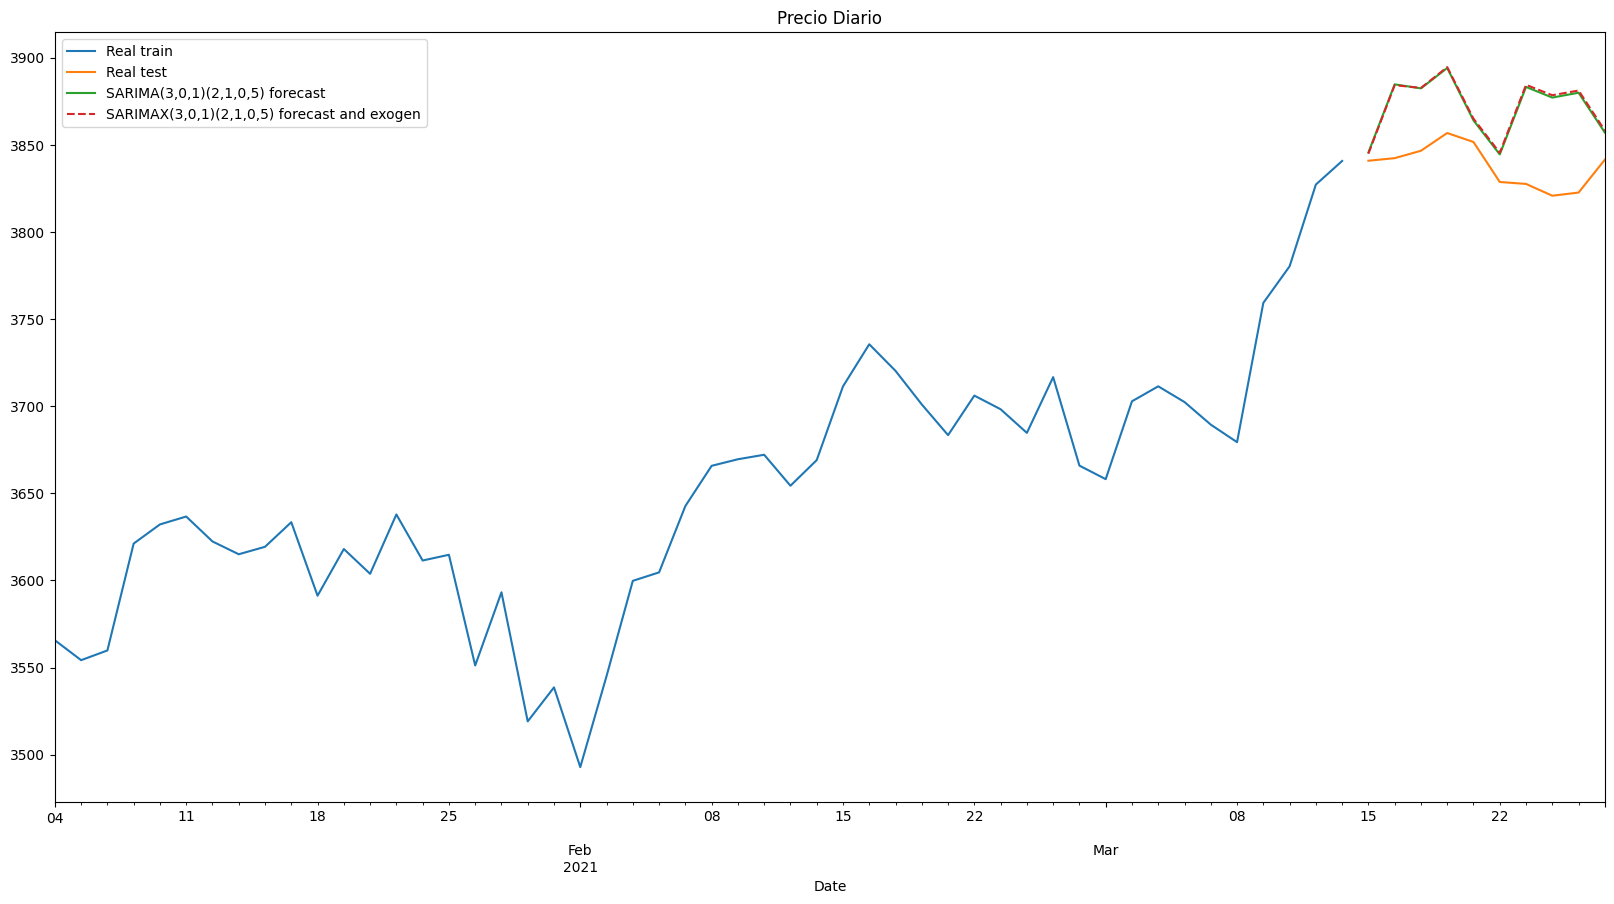

In [ ]:
fig, ax = plt.subplots()
ax = wd_train.Open[800:].plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real train')
ax = wd_test.Open.plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real test')

model_sarima = SARIMAX(wd_train.Open, order=(3,0,1),seasonal_order=(2,1,0,5), enforce_invertibility=False)
results_sarima = model_sarima.fit()
results_sarimafore = results_sarima.forecast(steps=10)
results_sarimafore.index=wd_test.Open.index

model_sarimax = SARIMAX(wd_train.Open, exog=wd_train[best_topic], order=(3,0,1),seasonal_order=(2,1,0,5), enforce_invertibility=False)
sarimax_results = model_sarimax.fit()
results_sarimaxfore = sarimax_results.forecast(steps=10, exog=exog_forecast)
results_sarimaxfore.index=wd_test.Open.index


ax = results_sarimafore.plot(ax=ax, label='SARIMA(3,0,1)(2,1,0,5) forecast', linestyle='-')
ax = results_sarimaxfore.plot(ax=ax, label='SARIMAX(3,0,1)(2,1,0,5) forecast and exogen', linestyle='--')
plt.legend(loc="upper left")
plt.show()


## Conclusiones finales

Como podemos observar, el cambio sigue siendo mínimo con la inclusión de variables exógenas, en comparación con la predicción de SARIMA sin estas. Por lo cual, la conclusión es que el análisis de sentimiento de las noticias, aunque valioso como herramienta de análisis exógena, no proporciona un cambio significativo en la precisión de nuestras predicciones de precios de acciones en este caso específico.

Esta observación sugiere que, para el conjunto de datos y el periodo de tiempo analizados, los factores de mercado capturados por el modelo SARIMA (Seasonal AutoRegressive Integrated Moving Average) podrían tener una influencia más dominante en la dinámica de los precios de las acciones que los sentimientos derivados de las noticias. Esto no descarta la relevancia del análisis de sentimiento en otros contextos o con diferentes conjuntos de datos, pero indica que en este escenario particular, el impacto de las noticias exógenas, tal como se ha medido, es limitado en la mejora de la predicción de precios de acciones.

Es importante considerar que este resultado podría variar con diferentes metodologías de análisis de sentimientos, con la inclusión de otras variables exógenas o en diferentes condiciones de mercado. Además, podrían explorarse métodos más avanzados o personalizados de análisis de sentimiento para evaluar si estos pueden ofrecer una mejor correlación con los movimientos del mercado de valores.